In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import utils
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import financepy
from financepy.utils import *
from financepy.products.bonds import *
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

####################################################################
# FINANCEPY BETA Version 0.230 - This build:  02 Apr 2024 at 11:53 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [2]:
# Taking gbp, eur, usd swap rates data from bloomberg excel file and creating dataframes
excel_file = "Bloomberg - Historical Data v2.03.xlsx"
data = pd.read_excel(excel_file, sheet_name=None)
gbp_ois_df = data['gbp ois results'].dropna()
eur_estr_df = data['eur estr results'].dropna()
usd_sofr_df = data['usd sofr results'].dropna()

# Using the get_swap_rates function from the utils.py file to transform the swap rates data into a better format to work with
# The dataframes contain a column of dates, and swap rates on each day for each given maturity
# _full means swap rates data for the full set of maturities of the term structure (i.e. 1 week, 2 weeks, ...., 50y)
# _long means swap rates data for the maturities of the long end of the curve (i.e. 2y, 3y, ..., 50y)
# _7_mat means swap rates data for seven maturities of the term structure (2y, 3y, 5y, 10y, 15y, 20y, 30y), i.e. the seven maturities used in the original paper

gbp_ois_full = utils.get_swap_rates(gbp_ois_df, utils.gbp_ts_full)
gbp_ois_long = utils.get_swap_rates(gbp_ois_df, utils.gbp_ts_long)
gbp_ois_7_mat = utils.get_swap_rates(gbp_ois_df, utils.gbp_ts_7_mat)

eur_estr_full = utils.get_swap_rates(eur_estr_df, utils.eur_ts_full)
eur_estr_long = utils.get_swap_rates(eur_estr_df, utils.eur_ts_long)
eur_estr_7_mat = utils.get_swap_rates(eur_estr_df, utils.eur_ts_7_mat)

usd_sofr_full = utils.get_swap_rates(usd_sofr_df, utils.usd_ts_full)
usd_sofr_long = utils.get_swap_rates(usd_sofr_df, utils.usd_ts_long)
usd_sofr_7_mat = utils.get_swap_rates(usd_sofr_df, utils.usd_ts_7_mat)

In [3]:
# Head of GBP (OIS) swap rates
gbp_ois_7_mat.head()

,dates,2Y,3Y,5Y,10Y,15Y,20Y,30Y
0,2022-01-27,1.2350,1.29400,1.26005,1.15820,1.1148,1.0665,0.9812
1,2022-01-28,1.2674,1.32300,1.28260,1.18135,1.1387,1.0938,1.0158
2,2022-01-31,1.3339,1.39285,1.33050,1.22800,1.1860,1.1440,1.0670
3,2022-02-01,1.3218,1.38600,1.32930,1.22400,1.1779,1.1330,1.0560
4,2022-02-02,1.3010,1.36000,1.30800,1.19700,1.1470,1.0960,1.0110


### Building the VAE

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean((1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)))
            kl_loss *= self.beta #TODO: NEED TO TUNE THIS HYPERPARAMETER : 0.001 seems decent (for standard VAE model) (tested on training data only)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        # self.optimizer.learning_rate = self.lr
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Building the encoder and decoder for the VAE (for single-currency VAE, multi-currency VAE and multi-currency CVAE)

In [5]:
# The following encoder/decoder works only for swap rates data with 7 maturities. Simply change input and output layer to accomodate for larger number of rates

def build_encoder(latent_dims, num_maturities, type='multi_currency', num_currencies=0):
    encoder_input = keras.Input(shape=(num_maturities + num_currencies,))
    if type == 'multi_currency':
        if num_currencies == 0:
            x = layers.Dense(7, activation="tanh")(encoder_input)
            x = layers.Dense(4)(x)
        else:
            x = layers.Dense(7 + num_currencies, activation="tanh")(encoder_input)
            x = layers.Dense(9)(x)
    elif type == 'single_currency':
        x = layers.Dense(4, activation="tanh")(encoder_input)
        x = layers.Dense(4)(x)
    else:
        raise ValueError("!")
    mean = layers.Dense(latent_dims, name="z_mean")(x)
    log_var = layers.Dense(latent_dims, name="z_log_var")(x)
    z = Sampling()([mean, log_var])
    encoder = keras.Model(encoder_input, [mean, log_var, z], name="encoder123")
    return encoder

def build_decoder(latent_dims, num_maturities, type='multi_currency', num_currencies=0):
    latent_input = keras.Input(shape=(latent_dims,))
    if type == 'multi_currency':
        if num_currencies == 0:
            x = layers.Dense(4, activation="tanh")(latent_input)
            x = layers.Dense(7, activation="tanh")(x)
        else:
            x = layers.Dense(7, activation="tanh")(latent_input)
            x = layers.Dense(7, activation="tanh")(x)  
    elif type == 'single_currency':
        x = layers.Dense(4, activation="tanh")(latent_input)
    else:
        raise ValueError("!")
    decoder_output = layers.Dense(num_maturities + num_currencies, activation="sigmoid")(x)
    decoder = keras.Model(latent_input, decoder_output, name="decoder")
    return decoder

In [6]:
# The following functions are used to transform the original swaps data from bloomberg into data that will be passed into the VAE

def single_currency_scale_swaps(swap_rates_df):
    """
    swap_rates_df: swap rates dataframe with the dates column
    This function returns the scaled swap rates and the scaler (needed to invert the scaling after encoding using the VAE)
    The scaler is returned to reverse the MinMax scaling process to de-scale the swaps rates that are reconstructed by the VAE
    """
    df = swap_rates_df.copy()
    swap_vals = df.iloc[:,1:].values
    scaler = MinMaxScaler()
    scaled_swaps = scaler.fit_transform(swap_vals)

    return scaled_swaps, scaler

def multi_currency_scale_swaps(conditional=False, **kwargs):
    """
    conditional: Set conditional=True to get one hot encoded data that is needed for CVAE. Else, set conditional=False
    **kwargs: Pass in dataframes of swap rates data for each currency (including dates). e.g pass in gbp=gbp_ois_7_mat, usd=usd_sofr_7_mat, eur=eur_estr_7_mat
    This function takes swap rates for an arbitrary number of currencies and returns scaled swap rates and the scaler. If conditional=True, the swap rates include one hot encoding.
    The scaler is returned to reverse the MinMax scaling process to de-scale the swaps rates that are reconstructed by the VAE
    This function also returns currency_index_list which gives you the final indices of each currency in the combined swap rates data, allowing you to split the data into separate currencies.
    """
    currency_index_list = []
    idx = 0
    for i, (label, df_) in enumerate(kwargs.items()):
        df = df_.copy()
        idx += df.shape[0]
        currency_index_list.append(idx)
        if conditional == True:
            df['currency'] = label
        if i == 0:
            multi_curr_df = df
        else:
            multi_curr_df = pd.concat((multi_curr_df, df))
    if conditional == False:
        scaled_swaps, scaler = single_currency_scale_swaps(multi_curr_df.iloc[:, :])
        return scaled_swaps, scaler, currency_index_list
    
    multi_curr_df = multi_curr_df.reset_index().drop(columns=['index'])

    ohe = OneHotEncoder()
    currency_encoding = ohe.fit_transform(multi_curr_df[['currency']])
    currency_encoding = pd.DataFrame(currency_encoding.toarray(), columns=ohe.get_feature_names_out(['currency']))

    scaler = MinMaxScaler()
    multi_curr_df = multi_curr_df.drop(columns=['dates', 'currency'])
    multi_curr_df = scaler.fit_transform(multi_curr_df)
    multi_curr_scaled_swaps = pd.DataFrame(multi_curr_df)
    multi_curr_scaled_swaps = pd.concat((multi_curr_scaled_swaps, currency_encoding), axis=1)
    multi_curr_scaled_swaps = multi_curr_scaled_swaps.iloc[:, :].values

    return multi_curr_scaled_swaps, scaler, currency_index_list

In [7]:
def plot_latent_space(vae, data, labels=None, save=None, plot_label=None):
    """
    This function uses the trained vae object to encode the swap rates passed in, and plots the encoded data.
    If labels are passed, the plot will be colour coded by currency.
    Note: label_dict is currently hard-coded
    - vae: trained VAE
    - data: np.array of daily swap rates. The data should be in the order GBP -> USD -> EUR, and as a np.array
    - labels: np.array of labels. 0: GBP, 1: USD, 2: EUR
    """
    _, _, z = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(6, 4))
    if labels == None:
        plt.scatter(z[:, 0], z[:, 1])
    else:
        unique_labels = np.unique(labels) if labels is not None else []
        label_dict = {0: 'GBP', 1: 'USD', 2: 'EUR'} # TODO: this dict is hard-coded - write it in a general way
        for i, label in enumerate(unique_labels):
            indices = np.where(labels == label)[0]
            plt.scatter(z[indices, 0], z[indices, 1], label=f'{label_dict[i]}')

    plt.xlabel("Latent Space Dimension 1, $z_1$")
    plt.ylabel("Latent Space Dimension 2, $z_2$")
    plt.title(f"Latent Space ({plot_label})")
    plt.axis('equal')
    plt.legend()
    if save:
        plt.savefig(save + '.png', dpi=300)
    plt.show()

### Example of using the single-currency VAE on the USD swap rates data with 7 maturities

In [8]:
# Transforming the swaps data so that it can be passed into the single-currency VAE (using GBP in this example)
usd_scaled_swaps, usd_scaler = single_currency_scale_swaps(usd_sofr_7_mat)

# Creating the encoder and decoder for single-currency VAE
usd_encoder = build_encoder(latent_dims=2, num_maturities=7, type='single_currency')
usd_decoder = build_decoder(latent_dims=2, num_maturities=7, type='single_currency')

In [9]:
# Creating the VAE using the single-currency encoder and decoder and then training the VAE using the scaled swaps data
# Note: beta is the coefficient of the KL divergence loss term in the VAE # TODO: maybe tune the beta hyperparameter for better results (might be difficult with lack of single currency data)
usd_vae = VAE(usd_encoder, usd_decoder, beta=1e-03)
usd_vae.compile(optimizer=keras.optimizers.Adam())
usd_vae.fit(usd_scaled_swaps, epochs=50, batch_size=8)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 2.3216e-04 - loss: 0.0662 - reconstruction_loss: 0.0659 - total_loss: 0.0638
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 4.2261e-04 - loss: 0.0542 - reconstruction_loss: 0.0538 - total_loss: 0.0540
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 6.0865e-04 - loss: 0.0503 - reconstruction_loss: 0.0496 - total_loss: 0.0476
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 7.4771e-04 - loss: 0.0431 - reconstruction_loss: 0.0424 - total_loss: 0.0439
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 8.6124e-04 - loss: 0.0406 - reconstruction_loss: 0.0397 - total_loss: 0.0378
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 9.5175e-04 - loss: 0.0369 - reconstruction_loss: 0.0359 - total_loss: 0.0321
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0011 - loss: 0.0230 - reconstruction_loss: 0.0219 - total_loss: 0.0225
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


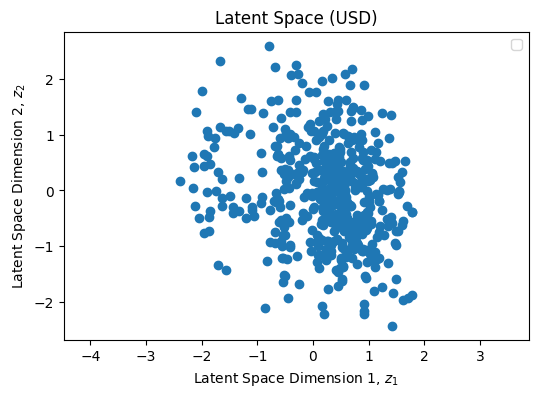

In [10]:
# Plotting the latent space of the VAE using the plot_latent_space function
plot_latent_space(usd_vae, usd_scaled_swaps, plot_label='USD')

In [11]:
# Now that we have a trained VAE, we can pass daily swap rates data into the encoder to get the coordinates of the corresponding latent space representation 
# We also obtain the mean and log variance of the distribution of the latent space
# We pass the coordinates of the latent space representation into the decoder to get the reconstructed swap rates, and then invert the MinMax scaling
# Note, here we have trained the VAE on IN-SAMPLE data and then reconstructed the IN-SAMPLE data (i.e. we have not split into in-sample/out-of-sample here)
mean_usd, logvar_usd, z_usd = usd_vae.encoder(usd_scaled_swaps)
usd_reconstructed_swaps = usd_vae.decoder(z_usd).numpy()
usd_reconstructed_swaps = usd_scaler.inverse_transform(usd_reconstructed_swaps)

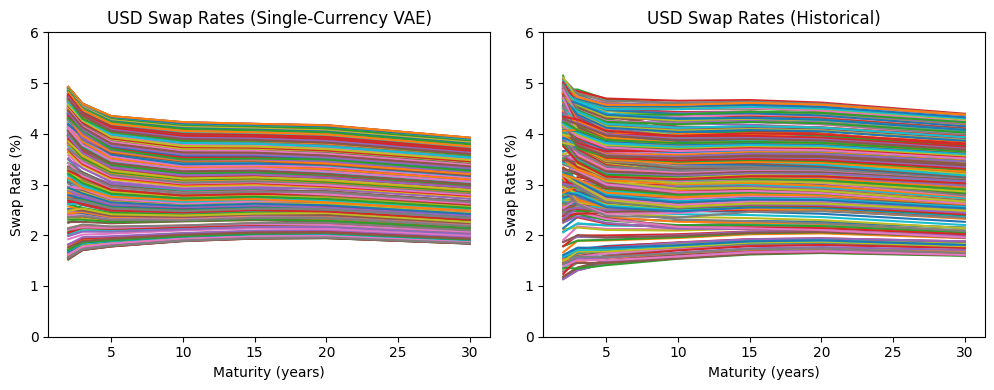

In [12]:
seven_mat = np.array([2, 3, 5, 10, 15, 20, 30]) # seven_mat refers to the seven maturities 2y, 3y, 5y, 10y, 15y, 20y, 30y used in the original paper

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 2) 
for i in range(len(usd_sofr_7_mat)):
    plt.plot(seven_mat, usd_sofr_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('USD Swap Rates (Historical)')
plt.ylim(0, 6)

plt.subplot(1, 3, 1) 
for i in range(usd_reconstructed_swaps.shape[0]):
    plt.plot(seven_mat, usd_reconstructed_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('USD Swap Rates (Single-Currency VAE)')
plt.ylim(0, 6)

plt.tight_layout()
# plt.savefig('usd_reconstr_histor.png', dpi=300)
plt.show()

In [13]:
# Doing the same as above for  USD and EUR swap rates

gbp_scaled_swaps, gbp_scaler = single_currency_scale_swaps(gbp_ois_7_mat)
gbp_encoder = build_encoder(latent_dims=2, num_maturities=7, type='single_currency')
gbp_decoder = build_decoder(latent_dims=2, num_maturities=7, type='single_currency')
gbp_vae = VAE(gbp_encoder, gbp_decoder, beta=1e-03)
gbp_vae.compile(optimizer=keras.optimizers.Adam())
gbp_vae.fit(gbp_scaled_swaps, epochs=50, batch_size=8)
mean_gbp, logvar_gbp, z_gbp = gbp_vae.encoder(gbp_scaled_swaps)
gbp_reconstructed_swaps = gbp_vae.decoder(z_gbp).numpy()
gbp_reconstructed_swaps = gbp_scaler.inverse_transform(gbp_reconstructed_swaps)

eur_scaled_swaps, eur_scaler = single_currency_scale_swaps(eur_estr_7_mat)
eur_encoder = build_encoder(latent_dims=2, num_maturities=7, type='single_currency')
eur_decoder = build_decoder(latent_dims=2, num_maturities=7, type='single_currency')
eur_vae = VAE(eur_encoder, eur_decoder, beta=1e-03)
eur_vae.compile(optimizer=keras.optimizers.Adam())
eur_vae.fit(eur_scaled_swaps, epochs=50, batch_size=8)
mean_eur, logvar_eur, z_eur = eur_vae.encoder(eur_scaled_swaps)
eur_reconstructed_swaps = eur_vae.decoder(z_eur).numpy()
eur_reconstructed_swaps = eur_scaler.inverse_transform(eur_reconstructed_swaps)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - kl_loss: 5.5447e-04 - loss: 0.0725 - reconstruction_loss: 0.0719 - total_loss: 0.0716
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 5.5817e-04 - loss: 0.0630 - reconstruction_loss: 0.0624 - total_loss: 0.0597
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - kl_loss: 7.8460e-04 - loss: 0.0444 - reconstruction_loss: 0.0436 - total_loss: 0.0465
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 7.3778e-04 - loss: 0.0392 - reconstruction_loss: 0.0384 - total_loss: 0.0370
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 9.3691e-04 - loss: 0.0291 - reconstruction_loss: 0.0282 - total_loss: 0.0261
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 9.5408e-04 - loss: 0.0203 - reconstruction_loss: 0.0193 - total_loss: 0.0187
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - kl_loss: 0.0012 - loss: 0.0157 - reconstruction_loss: 0.0145 - total_loss: 0.0156
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━

### Example of using the multi-currency VAE on swap rates data with 7 maturities for all currencies 

In [14]:
# Transforming the swaps data of each currency so that it can be passed into the multi-currency VAE (using GBP, USD, EUR in this example)
# We obtain scaled swaps, the scaler, and also the indices of the scaled swaps dataframe corresponding to each currency
multi_curr_scaled_swaps, multi_curr_scaler, multi_curr_indexes = multi_currency_scale_swaps(conditional=False, gbp=gbp_ois_7_mat, usd=usd_sofr_7_mat, eur=eur_estr_7_mat)

# Creating the encoder and decoder for a multi-currency VAE
mc_encoder = build_encoder(latent_dims=2, num_maturities=7, type='multi_currency')
mc_decoder = build_decoder(latent_dims=2, num_maturities=7, type='multi_currency') 

In [15]:
# Creating the VAE using the multi-currency encoder and decoder and then training the VAE using the the swap rates data of all currencies
mc_vae = VAE(mc_encoder, mc_decoder, beta=1e-3)
mc_vae.compile(optimizer=keras.optimizers.Adam())
mc_vae.fit(multi_curr_scaled_swaps, epochs=50, batch_size=8)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - kl_loss: 4.8711e-04 - loss: 0.0494 - reconstruction_loss: 0.0488 - total_loss: 0.0406
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - kl_loss: 8.1891e-04 - loss: 0.0241 - reconstruction_loss: 0.0233 - total_loss: 0.0191
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0015 - loss: 0.0088 - reconstruction_loss: 0.0072 - total_loss: 0.0078
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0020 - loss: 0.0062 - reconstruction_loss: 0.0042 - total_loss: 0.0062
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0022 - loss: 0.0055 - reconstruction_loss: 0.0033 - total_loss: 0.0054
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - kl_loss: 0.0022 - loss: 0.0049 - reconstruction_loss: 0.0027 - total_loss: 0.0049
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - kl_loss: 0.0023 - loss: 0.0049 - reconstruction_loss: 0.0026 - total_loss: 0.0047
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━

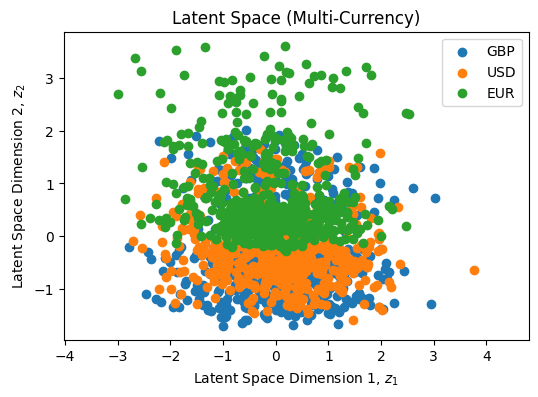

In [16]:
labels1 = [1]*multi_curr_indexes[0] + [2]*(multi_curr_indexes[1] - multi_curr_indexes[0]) + [3]*(multi_curr_indexes[2] - multi_curr_indexes[1])
# plot_latent_space(mc_vae, multi_curr_scaled_swaps, labels=list(labels1), plot_label='Multi-Currency VAE', save='multi_vae_latent_space')
plot_latent_space(mc_vae, multi_curr_scaled_swaps, labels=list(labels1), plot_label='Multi-Currency')

In [17]:
mean1, logvar1, z1 = mc_vae.encoder(multi_curr_scaled_swaps)
reconstructed_mc_swaps = mc_vae.decoder(z1).numpy()
reconstructed_mc_swaps = multi_curr_scaler.inverse_transform(reconstructed_mc_swaps)

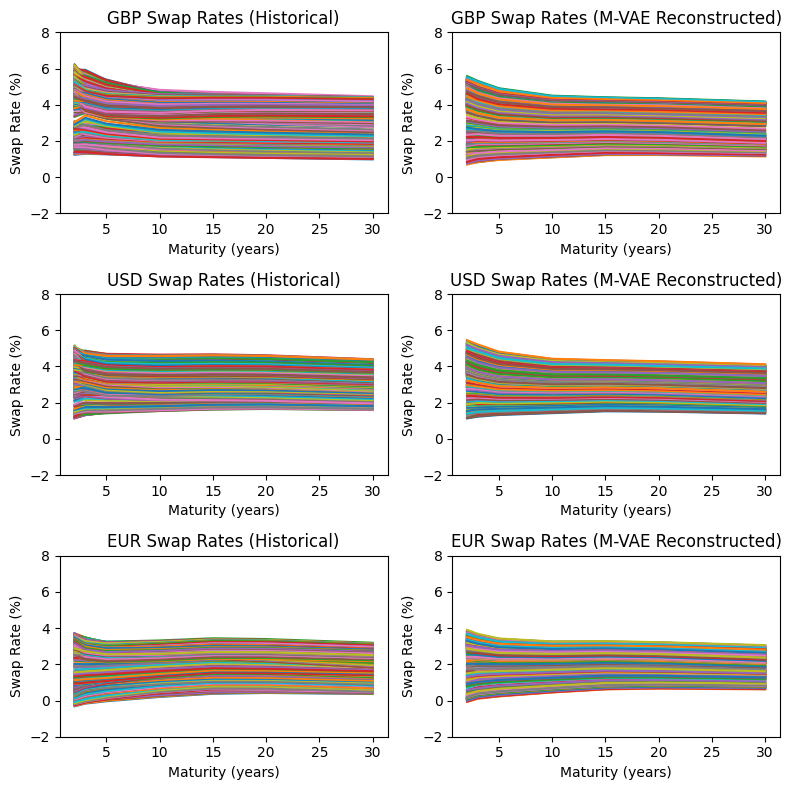

In [18]:
plt.figure(figsize=(8, 8))

plt.subplot2grid((3, 2), (0, 0), colspan=1) 
for i in range(len(gbp_ois_7_mat)):
    plt.plot(seven_mat, gbp_ois_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('GBP Swap Rates (Historical)')
plt.ylim(-2, 8)

gbp_reconstructed_mc_swaps = reconstructed_mc_swaps[:multi_curr_indexes[0]]
plt.subplot2grid((3, 2), (0, 1), colspan=1) 
for i in range(gbp_reconstructed_mc_swaps.shape[0]):
    plt.plot(seven_mat, gbp_reconstructed_mc_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('GBP Swap Rates (M-VAE Reconstructed)')
plt.ylim(-2, 8)

plt.subplot2grid((3, 2), (1, 0), colspan=1) 
for i in range(len(usd_sofr_7_mat)):
    plt.plot(seven_mat, usd_sofr_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('USD Swap Rates (Historical)')
plt.ylim(-2, 8)

usd_reconstructed_mc_swaps = reconstructed_mc_swaps[multi_curr_indexes[0]:multi_curr_indexes[1]]
plt.subplot2grid((3, 2), (1, 1), colspan=1) 
for i in range(usd_reconstructed_mc_swaps.shape[0]):
    plt.plot(seven_mat, usd_reconstructed_mc_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('USD Swap Rates (M-VAE Reconstructed)')
plt.ylim(-2, 8)

plt.subplot2grid((3, 2), (2, 0), colspan=1) 
for i in range(len(eur_estr_7_mat)):
    plt.plot(seven_mat, eur_estr_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('EUR Swap Rates (Historical)')
plt.ylim(-2, 8)

eur_reconstructed_mc_swaps = reconstructed_mc_swaps[multi_curr_indexes[1]:multi_curr_indexes[2]]
plt.subplot2grid((3, 2), (2, 1), colspan=1) 
for i in range(eur_reconstructed_mc_swaps.shape[0]):
    plt.plot(seven_mat, eur_reconstructed_mc_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('EUR Swap Rates (M-VAE Reconstructed)')
plt.ylim(-2, 8)

plt.tight_layout()
# plt.savefig('multi_vae_histor_reconst.png', dpi=300)
plt.show()

### Example of using the multi-currency $\bf{conditional}$-VAE on swap rates data with 7 maturities for all currencies

In [19]:
# Transforming the swaps data of each currency so that it can be passed into the multi-currency conditional-VAE (using GBP, USD, EUR in this example)
multi_curr_cond_scaled_swaps, multi_curr_cond_scaler, multi_curr_cond_indexes = multi_currency_scale_swaps(conditional=True, gbp=gbp_ois_7_mat, usd=usd_sofr_7_mat, eur=eur_estr_7_mat)

# Creating the encoder and decoder for a multi-currency conditional VAE
mc_c_encoder = build_encoder(latent_dims=2, num_maturities=7, type='multi_currency', num_currencies=3)
mc_c_decoder = build_decoder(latent_dims=2, num_maturities=7, type='multi_currency', num_currencies=3)

In [20]:
# Creating the conditional VAE using the multi-currency conditional encoder and decoder and then training the VAE using the the swap rates data of all currencies
mc_cvae = VAE(encoder=mc_c_encoder, decoder=mc_c_decoder, beta=1e-3) # TODO: tune beta
mc_cvae.compile(optimizer=keras.optimizers.Adam())
mc_cvae.fit(multi_curr_cond_scaled_swaps, epochs=50, batch_size=8)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step - kl_loss: 3.1186e-04 - loss: 0.1024 - reconstruction_loss: 0.1020 - total_loss: 0.0872
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - kl_loss: 0.0018 - loss: 0.0447 - reconstruction_loss: 0.0429 - total_loss: 0.0395
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0022 - loss: 0.0278 - reconstruction_loss: 0.0256 - total_loss: 0.0266
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - kl_loss: 0.0021 - loss: 0.0216 - reconstruction_loss: 0.0194 - total_loss: 0.0209
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0023 - loss: 0.0176 - reconstruction_loss: 0.0154 - total_loss: 0.0174
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - kl_loss: 0.0024 - loss: 0.0158 - reconstruction_loss: 0.0134 - total_loss: 0.0149
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - kl_loss: 0.0024 - loss: 0.0132 - reconstruction_loss: 0.0108 - total_loss: 0.0127
Epoch 8/50
196/196 ━━━━━━━━━━━━━━

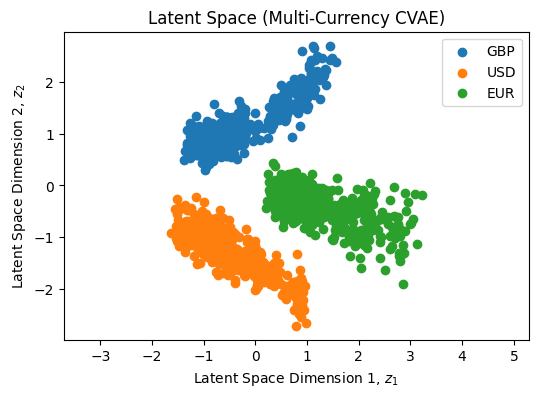

In [21]:
labels2 = [1]*multi_curr_cond_indexes[0] + [2]*(multi_curr_cond_indexes[1] - multi_curr_cond_indexes[0]) + [3]*(multi_curr_cond_indexes[2] - multi_curr_cond_indexes[1])
plot_latent_space(mc_cvae, multi_curr_cond_scaled_swaps, labels=list(labels2), plot_label='Multi-Currency CVAE', save='multi_cvae_latent_space')

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


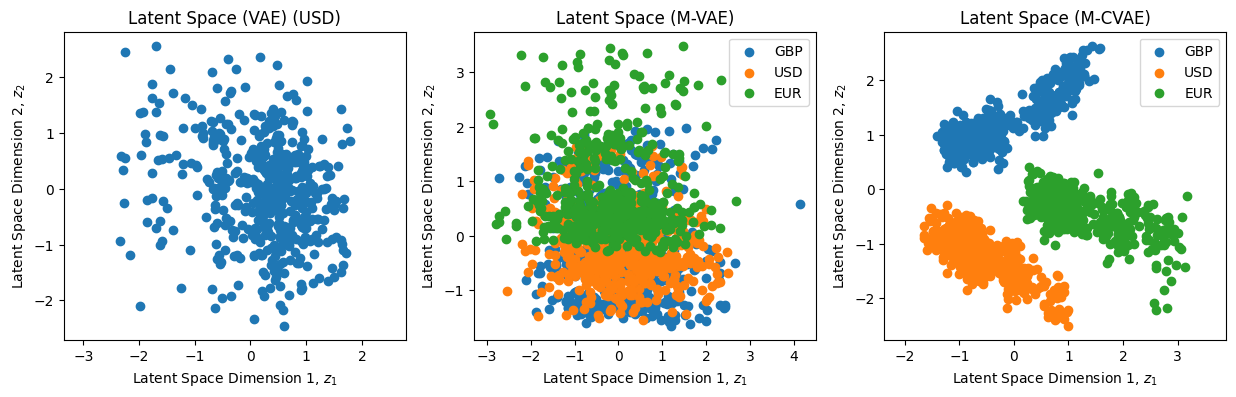

In [22]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1) 
_, _, z = usd_vae.encoder.predict(usd_scaled_swaps)
plt.scatter(z[:, 0], z[:, 1])
plt.xlabel("Latent Space Dimension 1, $z_1$")
plt.ylabel("Latent Space Dimension 2, $z_2$")
plt.title("Latent Space (VAE) (USD)")
plt.axis('equal')
# plt.xlim(-3, 2)
# plt.ylim(-2, 4)

plt.subplot(1, 3, 2) 
_, _, z = mc_vae.encoder.predict(multi_curr_scaled_swaps)
# plt.scatter(z[:, 0], z[:, 1])
unique_labels = np.unique(labels1) if labels1 is not None else []
label_dict = {0: 'GBP', 1: 'USD', 2: 'EUR'} # TODO: this dict is hard-coded - write it in a general way
for i, label in enumerate(unique_labels):
    indices = np.where(labels1 == label)[0]
    plt.scatter(z[indices, 0], z[indices, 1], label=f'{label_dict[i]}')
plt.legend()
plt.xlabel("Latent Space Dimension 1, $z_1$")
plt.ylabel("Latent Space Dimension 2, $z_2$")
plt.title("Latent Space (M-VAE)")

plt.subplot(1, 3, 3) 
_, _, z = mc_cvae.encoder.predict(multi_curr_cond_scaled_swaps)
unique_labels = np.unique(labels2) if labels2 is not None else []
label_dict = {0: 'GBP', 1: 'USD', 2: 'EUR'} # TODO: this dict is hard-coded - write it in a general way
for i, label in enumerate(unique_labels):
    indices = np.where(labels2 == label)[0]
    plt.scatter(z[indices, 0], z[indices, 1], label=f'{label_dict[i]}')

plt.xlabel("Latent Space Dimension 1, $z_1$")
plt.ylabel("Latent Space Dimension 2, $z_2$")
plt.title("Latent Space (M-CVAE)")
plt.axis('equal')
plt.legend()
# plt.savefig('triple_latent_space.png', dpi=300)
plt.show()

In [23]:
# Encoding the scaled swaps data and then decoding to get the reconstructed swaps data
# Again, the VAE here was trained on all data, and now we are reconstructing the same data (no in-sample/out-of-sample split)
mean2, logvar2, z2 = mc_cvae.encoder(multi_curr_cond_scaled_swaps)
reconstructed_swaps2 = mc_cvae.decoder(z2).numpy()
reconstructed_swaps2_pred_labels = reconstructed_swaps2[:, 7:]
reconstructed_swaps2 = reconstructed_swaps2[:, :7]
reconstructed_swaps2 = multi_curr_cond_scaler.inverse_transform(reconstructed_swaps2)

In [24]:
# Using the indices returned by the multi_currency_scale_swaps function to seperate the gbp, usd and eur data
gbp_cvae_reconstructed = reconstructed_swaps2[:multi_curr_cond_indexes[0]]
usd_cvae_reconstructed = reconstructed_mc_swaps[multi_curr_indexes[0]:multi_curr_indexes[1]]
eur_cvae_reconstructed = reconstructed_mc_swaps[multi_curr_indexes[1]:multi_curr_indexes[2]]

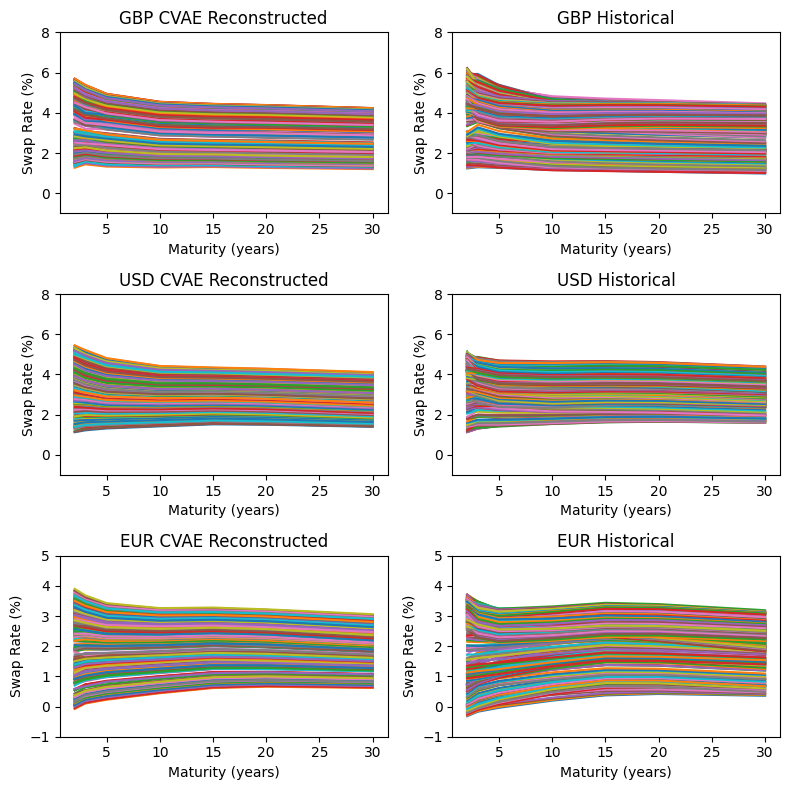

In [25]:
fig = plt.figure(figsize=(8, 8))

seven_mat = np.array([2, 3, 5, 10, 15, 20, 30])

# GBP subplot (GBP CVAE Reconstructed)
plt.subplot2grid((3, 2), (0, 0), colspan=1) 
for i in range(len(gbp_cvae_reconstructed)):
    plt.plot(seven_mat, gbp_cvae_reconstructed[i]) 
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('GBP CVAE Reconstructed')
plt.ylim(-1, 8)

# GBP subplot (GBP Historical)
plt.subplot2grid((3, 2), (0, 1), colspan=1)  
for i in range(len(gbp_ois_7_mat)):
    plt.plot(seven_mat, gbp_ois_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('GBP Historical')
plt.ylim(-1, 8)

# USD subplot (USD CVAE Reconstructed)
plt.subplot2grid((3, 2), (1, 0), colspan=1)
for i in range(len(usd_sofr_long)):
    plt.plot(seven_mat, usd_cvae_reconstructed[i]) 
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('USD CVAE Reconstructed')
plt.ylim(-1, 8)

# USD subplot (USD Historical)
plt.subplot2grid((3, 2), (1, 1), colspan=1)
for i in range(len(usd_sofr_7_mat)):
    plt.plot(seven_mat, usd_sofr_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('USD Historical')
plt.ylim(-1, 8)

# EUR subplot (EUR CVAE Reconstructed)
plt.subplot2grid((3, 2), (2, 0), colspan=1)
for i in range(len(eur_cvae_reconstructed)):
    plt.plot(seven_mat, eur_cvae_reconstructed[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('EUR CVAE Reconstructed')
plt.ylim(-1, 5)

# EUR subplot (EUR Historical)
plt.subplot2grid((3, 2), (2, 1), colspan=1)
for i in range(len(eur_estr_7_mat)):
    plt.plot(seven_mat, eur_estr_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('EUR Historical')
plt.ylim(-1, 5)

plt.tight_layout()
plt.show()

In [26]:
# Building the NS curves for each of the currencies

curveFitMethod = CurveFitNelsonSiegel()
tmax = np.max(seven_mat)
tmin = np.min(seven_mat)
grid_size = 100
t = np.linspace(tmin, int(tmax+0.5), grid_size)

gbp_ns_swaps = np.zeros((gbp_ois_7_mat.shape[0], grid_size))
eur_ns_swaps = np.zeros((eur_estr_7_mat.shape[0], grid_size))
usd_ns_swaps = np.zeros((usd_sofr_7_mat.shape[0], grid_size))


for i in range(gbp_ois_7_mat.shape[0]):
    popt, pcov = curve_fit(curveFitMethod._interpolated_yield, 
                        seven_mat, gbp_ois_7_mat.iloc[i, 1:].values, bounds=[(-5, -5, -5, 5), (5, 5, 5, 500)])
    p1, p2, p3, tau_, = popt[0], popt[1], popt[2], popt[3]
    res = curveFitMethod._interpolated_yield(t, p1, p2, p3, tau_)
    gbp_ns_swaps[i] = res

for i in range(eur_estr_7_mat.shape[0]):
    popt, pcov = curve_fit(curveFitMethod._interpolated_yield, 
                        seven_mat, eur_estr_7_mat.iloc[i, 1:].values, bounds=[(-10, -10, -10, 10), (10, 10, 10, 1000)])
    p1, p2, p3, tau_, = popt[0], popt[1], popt[2], popt[3]
    res = curveFitMethod._interpolated_yield(t, p1, p2, p3, tau_)
    eur_ns_swaps[i] = res

for i in range(usd_sofr_7_mat.shape[0]):
    popt, pcov = curve_fit(curveFitMethod._interpolated_yield, 
                        seven_mat, usd_sofr_7_mat.iloc[i, 1:].values, bounds=[(-5, -5, -5, 5), (5, 5, 5, 500)])
    p1, p2, p3, tau_, = popt[0], popt[1], popt[2], popt[3]
    res = curveFitMethod._interpolated_yield(t, p1, p2, p3, tau_)
    usd_ns_swaps[i] = res

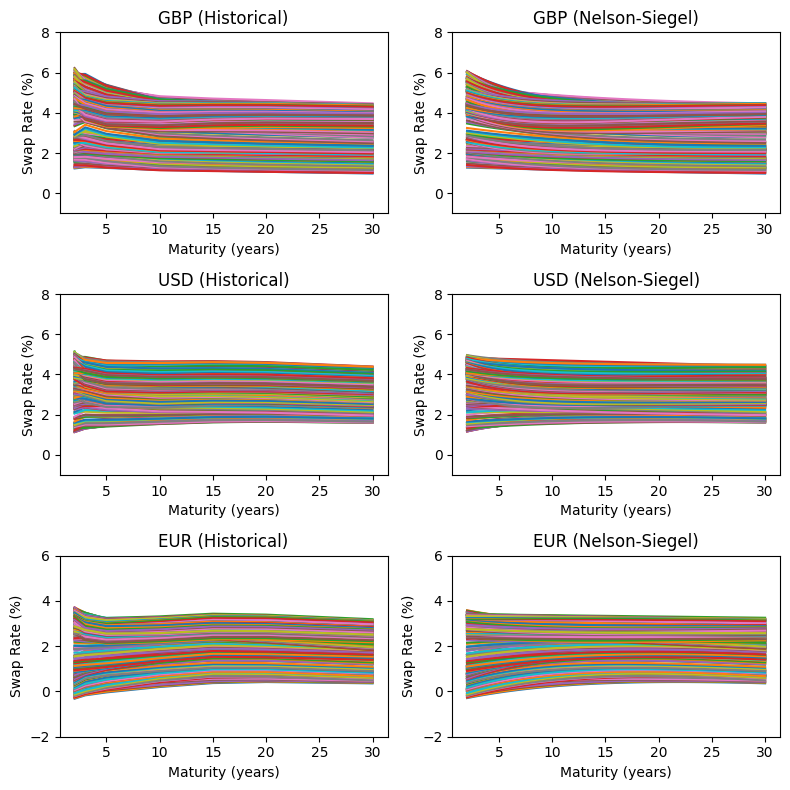

In [27]:
fig = plt.figure(figsize=(8, 8))

# GBP subplot (GBP NS)
plt.subplot2grid((3, 2), (0, 1))
for i in range(gbp_ns_swaps.shape[0]):
    plt.plot(t, gbp_ns_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('GBP (Nelson-Siegel)')
plt.ylim(-1, 8)

# GBP subplot (GBP Historical)
plt.subplot2grid((3, 2), (0, 0), colspan=1)  
for i in range(len(gbp_ois_7_mat)):
    plt.plot(seven_mat, gbp_ois_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('GBP (Historical)')
plt.ylim(-1, 8)

# USD subplot (USD NS)
plt.subplot2grid((3, 2), (1, 1))
for i in range(usd_ns_swaps.shape[0]):
    plt.plot(t, usd_ns_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('USD (Nelson-Siegel)')
plt.ylim(-1, 8)

# USD subplot (USD Historical)
plt.subplot2grid((3, 2), (1, 0), colspan=1)
for i in range(len(usd_sofr_7_mat)):
    plt.plot(seven_mat, usd_sofr_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('USD (Historical)')
plt.ylim(-1, 8)

# EUR subplot (EUR NS)
plt.subplot2grid((3, 2), (2, 1))
for i in range(eur_ns_swaps.shape[0]):
    plt.plot(t, eur_ns_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('EUR (Nelson-Siegel)')
plt.ylim(-2, 6)

# EUR subplot (EUR Historical)
plt.subplot2grid((3, 2), (2, 0), colspan=1)
for i in range(len(eur_estr_7_mat)):
    plt.plot(seven_mat, eur_estr_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('EUR (Historical)')
plt.ylim(-2, 6)

plt.tight_layout()
# plt.savefig('ns_histor_curves.png', dpi=300)
plt.show()

In [28]:
def calculate_rmse(reconstructed_rates, market_rates):
    """
    This function returns the RMSE for each day.
    Note: the rates are divided by 100 to get raw rates, and the function returns the rmse of the raw rates, not percentage rates
    reconstructed_rates - rates that are built using VAE or NS/NSS (np.array)
    market_rates - rates observed in the market (np.array)
    """
    reconstructed = reconstructed_rates.copy()
    market = market_rates.copy()
    assert reconstructed.shape[0] == market.shape[0]
    reconstructed /= 100
    market /= 100
    daily_rmse = np.sqrt(np.mean(np.square(reconstructed - market), axis=1)) * 10000 # multiplying by 10000 to get error into basis point units (bps)

    return daily_rmse

In [29]:
# Calculating the RMSE for each of the methods
# Note: ns means nelson-siegel, combined
combined_historical_swaps = pd.concat((gbp_ois_7_mat.copy(), usd_sofr_7_mat.copy()))
combined_historical_swaps = pd.concat((combined_historical_swaps, eur_estr_7_mat))
combined_historical_swaps = combined_historical_swaps.reset_index().drop(columns=['index'])

gbp_vae_daily_rmse = calculate_rmse(gbp_reconstructed_swaps, gbp_ois_7_mat.iloc[:, 1:].values)
usd_vae_daily_rmse = calculate_rmse(usd_reconstructed_swaps, usd_sofr_7_mat.iloc[:, 1:].values)
eur_vae_daily_rmse = calculate_rmse(eur_reconstructed_swaps, eur_estr_7_mat.iloc[:, 1:].values)
gbp_cvae_daily_rmse = calculate_rmse(gbp_cvae_reconstructed, gbp_ois_7_mat.iloc[:, 1:].values)
usd_cvae_daily_rmse = calculate_rmse(usd_cvae_reconstructed, usd_sofr_7_mat.iloc[:, 1:].values)
eur_cvae_daily_rmse = calculate_rmse(eur_cvae_reconstructed, eur_estr_7_mat.iloc[:, 1:].values)
gbp_ns_daily_rmse = calculate_rmse(gbp_ns_swaps[:, seven_mat], gbp_ois_7_mat.iloc[:, 1:].values)
usd_ns_daily_rmse = calculate_rmse(usd_ns_swaps[:, seven_mat], usd_sofr_7_mat.iloc[:, 1:].values)
eur_ns_daily_rmse = calculate_rmse(eur_ns_swaps[:, seven_mat], eur_estr_7_mat.iloc[:, 1:].values)

# Combining rmse for all currencies, for each of the methods (i.e. single curr vae, multi curr vae, multi curr conditional vae, and nelson-siegel)
combined_vae_daily_rmse = np.append(gbp_vae_daily_rmse, usd_vae_daily_rmse)
combined_vae_daily_rmse = np.append(combined_vae_daily_rmse, eur_vae_daily_rmse)
combined_mc_vae_daily_rmse = calculate_rmse(reconstructed_mc_swaps, combined_historical_swaps.iloc[:, 1:].values)
combined_cvae_daily_rmse = np.append(gbp_cvae_daily_rmse, usd_cvae_daily_rmse)
combined_cvae_daily_rmse = np.append(combined_cvae_daily_rmse, eur_cvae_daily_rmse)
combined_ns_daily_rmse = np.append(gbp_ns_daily_rmse, usd_ns_daily_rmse)
combined_ns_daily_rmse = np.append(combined_ns_daily_rmse, eur_ns_daily_rmse)

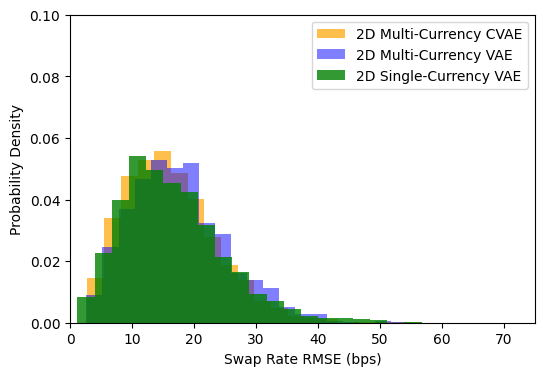

In [30]:
plt.figure(figsize=(6, 4))

plt.hist(combined_cvae_daily_rmse, bins=20, density=True, alpha=0.7, color='orange', label='2D Multi-Currency CVAE')
plt.hist(combined_mc_vae_daily_rmse, bins=20, density=True, alpha=0.5, color='blue', label='2D Multi-Currency VAE')
plt.hist(combined_vae_daily_rmse, bins=20, density=True, alpha=0.8, color='green', label='2D Single-Currency VAE')
plt.xlabel('Swap Rate RMSE (bps)')
plt.ylabel('Probability Density')
plt.xlim(0, 75)
plt.ylim(0, 0.1)
plt.legend()
# plt.savefig('rmse_3_vae.png', dpi=300)
plt.show()

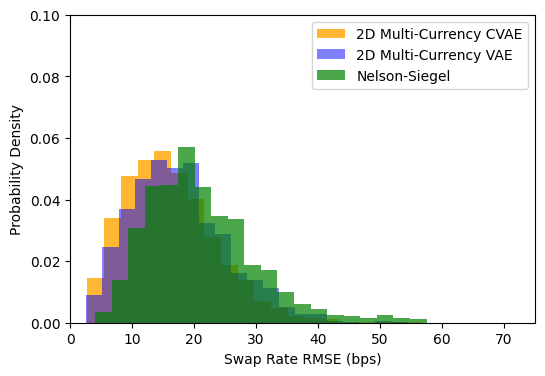

In [31]:
plt.figure(figsize=(6, 4))

plt.hist(combined_cvae_daily_rmse, bins=20, density=True, alpha=0.8, color='orange', label='2D Multi-Currency CVAE')
plt.hist(combined_mc_vae_daily_rmse, bins=20, density=True, alpha=0.5, color='blue', label='2D Multi-Currency VAE')
plt.hist(combined_ns_daily_rmse, bins=20, density=True, alpha=0.7, color='green', label='Nelson-Siegel')
plt.xlabel('Swap Rate RMSE (bps)')
plt.ylabel('Probability Density')
plt.xlim(0, 75)
plt.ylim(0, 0.1)
plt.legend()
# plt.savefig('rmse_mvae_ns.png', dpi=300)
plt.show()

### Example of doing out-of-sample comparison of single-currency vs. multi-currency VAE vs. multi-currency CVAE vs. Nelson-Siegel

In [32]:
# Basic cross-validation to find optimal beta
combined_dfs = pd.concat((gbp_ois_7_mat.copy(), usd_sofr_7_mat.copy()))
combined_dfs = pd.concat((combined_dfs, eur_estr_7_mat.copy()))
combined_swaps = combined_dfs
split = 0.8 # use a different split?
split_idx = int(combined_swaps.shape[0] * split)
combined_swaps_train = combined_swaps.iloc[:split_idx, :]
combined_swaps_test = combined_swaps.iloc[split_idx:, :]
combined_swaps_test = combined_swaps_test.iloc[:, 1:].values
k = 5
kf = KFold(n_splits=k)
beta_values = [0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.001, 0.005]
beta_opt = None
rmse_min = None
for beta in beta_values:
    total_rmse = 0
    for train_idx, val_idx in kf.split(combined_swaps_train):
        train_data, val_data = combined_swaps_train.iloc[train_idx], combined_swaps_train.iloc[val_idx]
        scaled_train_data, scaler, index_set = multi_currency_scale_swaps(conditional=False, combined=train_data)
        scaled_val_data = scaler.transform(val_data.iloc[:, 1:].values)

        encoder = build_encoder(latent_dims=2, num_maturities=7, type='multi_currency')
        decoder = build_decoder(latent_dims=2, num_maturities=7, type='multi_currency')
        vae = VAE(encoder, decoder, beta=beta)
        vae.compile(optimizer=keras.optimizers.Adam())
        vae.fit(scaled_train_data, epochs=30, batch_size=8)
        mean, logvar, z = vae.encoder(scaled_val_data)
        reconstructed_val_swaps = vae.decoder(z).numpy()
        reconstructed_val_swaps = scaler.inverse_transform(reconstructed_val_swaps)
        total_rmse += np.mean(calculate_rmse(reconstructed_val_swaps, val_data.iloc[:, 1:]))
    total_rmse /= k
    if rmse_min == None:
        rmse_min = total_rmse
        beta_opt = beta
    else:
        if total_rmse < rmse_min:
            rmse_min = total_rmse
            beta_opt = beta
    print('---------------------------')
    print('beta:', beta)
    print('total rmse: ', total_rmse)
    print('---------------------------')
print('beta_opt:', beta_opt)
print('rmse min: ', rmse_min)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 941us/step - kl_loss: 1.7128e-04 - loss: 0.0718 - reconstruction_loss: 0.0716 - total_loss: 0.0659
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - kl_loss: 4.2041e-04 - loss: 0.0551 - reconstruction_loss: 0.0547 - total_loss: 0.0503
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - kl_loss: 5.5521e-04 - loss: 0.0374 - reconstruction_loss: 0.0368 - total_loss: 0.0322
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 8.3632e-04 - loss: 0.0156 - reconstruction_loss: 0.0148 - total_loss: 0.0127
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - kl_loss: 0.0012 - loss: 0.0088 - reconstruction_loss: 0.0076 - total_loss: 0.0081
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - kl_loss: 0.0015 - loss: 0.0072 - reconstruction_loss: 0.0057 - total_loss: 0.0070
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - kl_loss: 0.0017 - loss: 0.0064 - reconstruction_loss: 0.0047 - total_loss: 0.0064
Epoch 8/30
125/125 ━

In [33]:
# Obtaining single-currency VAE out-of-sample results
df1 = gbp_ois_7_mat.copy()
df1['currency'] = 1
df2 = usd_sofr_7_mat.copy()
df2['currency'] = 2
df3 = eur_estr_7_mat.copy()
df3['currency'] = 3
combined_dfs = pd.concat((df1, df2))
combined_dfs = pd.concat((combined_dfs, df3))
combined_swaps = combined_dfs
combined_swaps = combined_swaps.sample(frac=1, random_state=42).reset_index(drop=True)
split = 0.70 # use a different split?
split_idx = int(combined_swaps.shape[0] * split)
combined_swaps_train = combined_swaps.iloc[:split_idx, :]
combined_swaps_test = combined_swaps.iloc[split_idx:, :]
gbp_swaps_train = combined_swaps_train[combined_swaps_train['currency'] == 1]
gbp_swaps_train = gbp_swaps_train.drop('currency', axis=1)
usd_swaps_train = combined_swaps_train[combined_swaps_train['currency'] == 2]
usd_swaps_train = usd_swaps_train.drop('currency', axis=1)
eur_swaps_train = combined_swaps_train[combined_swaps_train['currency'] == 3]
eur_swaps_train = eur_swaps_train.drop('currency', axis=1)

gbp_swaps_test = combined_swaps_test[combined_swaps_test['currency'] == 1]
gbp_swaps_test = gbp_swaps_test.drop('currency', axis=1)
usd_swaps_test = combined_swaps_test[combined_swaps_test['currency'] == 2]
usd_swaps_test = usd_swaps_test.drop('currency', axis=1)
eur_swaps_test = combined_swaps_test[combined_swaps_test['currency'] == 3]
eur_swaps_test = eur_swaps_test.drop('currency', axis=1)
gbp_swaps_test = gbp_swaps_test.iloc[:, 1:].values
usd_swaps_test = usd_swaps_test.iloc[:, 1:].values
eur_swaps_test = eur_swaps_test.iloc[:, 1:].values

gbp_scaled_swaps_train, gbp_scaler = single_currency_scale_swaps(gbp_swaps_train)
encoder = build_encoder(latent_dims=2, num_maturities=7, type='multi_currency')
decoder = build_decoder(latent_dims=2, num_maturities=7, type='multi_currency')
vae = VAE(encoder, decoder, beta=1e-03)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(gbp_scaled_swaps_train, epochs=20, batch_size=8)
gbp_scaled_swaps_test = gbp_scaler.transform(gbp_swaps_test)
mean, logvar, z = vae.encoder(gbp_scaled_swaps_test)
gbp_reconstructed_test_swaps = vae.decoder(z).numpy()
gbp_reconstructed_test_swaps = gbp_scaler.inverse_transform(gbp_reconstructed_test_swaps)

usd_scaled_swaps_train, usd_scaler = single_currency_scale_swaps(usd_swaps_train)
encoder = build_encoder(latent_dims=2, num_maturities=7, type='multi_currency')
decoder = build_decoder(latent_dims=2, num_maturities=7, type='multi_currency')
vae = VAE(encoder, decoder, beta=1e-03)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(usd_scaled_swaps_train, epochs=20, batch_size=8)
usd_scaled_swaps_test = usd_scaler.transform(usd_swaps_test)
mean, logvar, z = vae.encoder(usd_scaled_swaps_test)
usd_reconstructed_test_swaps = vae.decoder(z).numpy()
usd_reconstructed_test_swaps = usd_scaler.inverse_transform(usd_reconstructed_test_swaps)

eur_scaled_swaps_train, eur_scaler = single_currency_scale_swaps(eur_swaps_train)
encoder = build_encoder(latent_dims=2, num_maturities=7, type='multi_currency')
decoder = build_decoder(latent_dims=2, num_maturities=7, type='multi_currency')
vae = VAE(encoder, decoder, beta=1e-03)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(eur_scaled_swaps_train, epochs=20, batch_size=8)
eur_scaled_swaps_test = eur_scaler.transform(eur_swaps_test)
mean, logvar, z = vae.encoder(eur_scaled_swaps_test)
eur_reconstructed_test_swaps = vae.decoder(z).numpy()
eur_reconstructed_test_swaps = eur_scaler.inverse_transform(eur_reconstructed_test_swaps)

gbp_daily_rmse_OOS = calculate_rmse(gbp_reconstructed_test_swaps, gbp_swaps_test)
usd_daily_rmse_OOS = calculate_rmse(usd_reconstructed_test_swaps, usd_swaps_test)
eur_daily_rmse_OOS = calculate_rmse(eur_reconstructed_test_swaps, eur_swaps_test)
combined_vae_daily_rmse_OOS = np.append(gbp_daily_rmse_OOS, usd_daily_rmse_OOS)
combined_vae_daily_rmse_OOS = np.append(combined_vae_daily_rmse_OOS, eur_daily_rmse_OOS)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - kl_loss: 2.0784e-04 - loss: 0.0801 - reconstruction_loss: 0.0799 - total_loss: 0.0774
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - kl_loss: 2.6483e-04 - loss: 0.0661 - reconstruction_loss: 0.0659 - total_loss: 0.0675
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 4.2536e-04 - loss: 0.0618 - reconstruction_loss: 0.0614 - total_loss: 0.0605
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 5.8462e-04 - loss: 0.0569 - reconstruction_loss: 0.0562 - total_loss: 0.0522
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 6.5600e-04 - loss: 0.0414 - reconstruction_loss: 0.0406 - total_loss: 0.0366
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 8.1479e-04 - loss: 0.0238 - reconstruction_loss: 0.0230 - total_loss: 0.0209
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 9.9445e-04 - loss: 0.0157 - reconstruction_loss: 0.0147 - total_loss: 0.0136
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━

In [34]:
# Obtaining multi-currency VAE out-of-sample results
combined_dfs = pd.concat((gbp_ois_7_mat.copy(), usd_sofr_7_mat.copy()))
combined_dfs = pd.concat((combined_dfs, eur_estr_7_mat.copy()))
combined_swaps = combined_dfs
combined_swaps = combined_swaps.sample(frac=1, random_state=42).reset_index(drop=True)
split = 0.70 # use a different split?
split_idx = int(combined_swaps.shape[0] * split)
combined_swaps_train = combined_swaps.iloc[:split_idx, :]
combined_swaps_test = combined_swaps.iloc[split_idx:, :]
combined_swaps_test = combined_swaps_test.iloc[:, 1:].values
scaled_swaps_train, scaler, index_set = multi_currency_scale_swaps(conditional=False, combined=combined_swaps_train)
encoder = build_encoder(latent_dims=2, num_maturities=7, type='multi_currency')
decoder = build_decoder(latent_dims=2, num_maturities=7, type='multi_currency')
vae = VAE(encoder, decoder, beta=1e-03)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(scaled_swaps_train, epochs=50, batch_size=8)
scaled_swaps_test = scaler.transform(combined_swaps_test)
mean, logvar, z = vae.encoder(scaled_swaps_test)
reconstructed_test_swaps = vae.decoder(z).numpy()
reconstructed_test_swaps = scaler.inverse_transform(reconstructed_test_swaps)

mean_IS, logvar_IS, z_IS = vae.encoder(scaled_swaps_train)
reconstructed_train_swaps = vae.decoder(z_IS).numpy()
reconstructed_train_swaps = scaler.inverse_transform(reconstructed_train_swaps)

daily_rmse_OOS = calculate_rmse(reconstructed_test_swaps, combined_swaps_test)
daily_rmse_IS = calculate_rmse(reconstructed_train_swaps, combined_swaps_train.iloc[:, 1:])

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 836us/step - kl_loss: 1.2770e-04 - loss: 0.0575 - reconstruction_loss: 0.0573 - total_loss: 0.0514
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - kl_loss: 1.8844e-04 - loss: 0.0435 - reconstruction_loss: 0.0433 - total_loss: 0.0420
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - kl_loss: 5.2680e-04 - loss: 0.0384 - reconstruction_loss: 0.0378 - total_loss: 0.0345
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - kl_loss: 5.3389e-04 - loss: 0.0160 - reconstruction_loss: 0.0155 - total_loss: 0.0134
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - kl_loss: 0.0010 - loss: 0.0082 - reconstruction_loss: 0.0071 - total_loss: 0.0078
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0013 - loss: 0.0067 - reconstruction_loss: 0.0054 - total_loss: 0.0062
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - kl_loss: 0.0014 - loss: 0.0059 - reconstruction_loss: 0.0046 - total_loss: 0.0056
Epoch 8/50
137/137 ━

In [35]:
# Obtaining multi-currency CVAE out-of-sample results
df1 = gbp_ois_7_mat.copy()
df1['currency'] = 1
df2 = usd_sofr_7_mat.copy()
df2['currency'] = 2
df3 = eur_estr_7_mat.copy()
df3['currency'] = 3
combined_dfs = pd.concat((df1, df2))
combined_dfs = pd.concat((combined_dfs, df3))
combined_swaps = combined_dfs
combined_swaps = combined_swaps.sample(frac=1, random_state=42).reset_index(drop=True)

split = 0.70 # use a different split?
split_idx = int(combined_swaps.shape[0] * split)
combined_swaps_train = combined_swaps.iloc[:split_idx, :]
combined_swaps_test = combined_swaps.iloc[split_idx:, :]
combined_swaps_test = combined_swaps_test.iloc[:, 1:].values
gbp_train = combined_swaps_train[combined_swaps_train['currency'] == 1].drop('currency', axis=1)
usd_train = combined_swaps_train[combined_swaps_train['currency'] == 2].drop('currency', axis=1)
eur_train = combined_swaps_train[combined_swaps_train['currency'] == 3].drop('currency', axis=1)
scaled_swaps_train, scaler, index_set = multi_currency_scale_swaps(conditional=True, gbp=gbp_train, usd=usd_train, eur=eur_train)
encoder = build_encoder(latent_dims=2, num_maturities=7, type='multi_currency', num_currencies=3)
decoder = build_decoder(latent_dims=2, num_maturities=7, type='multi_currency', num_currencies=3)
vae = VAE(encoder, decoder, beta=1e-03)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(scaled_swaps_train, epochs=50, batch_size=8)
scaled_swaps_test = scaler.transform(combined_swaps_test[:, :-1])

ohe = OneHotEncoder()
test = pd.DataFrame(scaled_swaps_test, columns=combined_swaps.columns[1:-1])
test['currency'] = combined_swaps_test[:, -1]
currency_encoding = ohe.fit_transform(test[['currency']])
currency_encoding = pd.DataFrame(currency_encoding.toarray(), columns=ohe.get_feature_names_out(['currency']))
test = pd.concat((test, currency_encoding), axis=1).drop('currency', axis=1)
scaled_swaps_test = test

mean, logvar, z = vae.encoder(scaled_swaps_test)
reconstructed_test_swaps = vae.decoder(z).numpy()
reconstructed_test_swaps_pred_labels = reconstructed_test_swaps[:, 7:]
reconstructed_test_swaps = reconstructed_test_swaps[:, :7]
reconstructed_test_swaps = multi_curr_cond_scaler.inverse_transform(reconstructed_test_swaps)

daily_rmse_OOS_cvae = calculate_rmse(reconstructed_test_swaps, combined_swaps_test[:, :-1])

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 858us/step - kl_loss: 3.7038e-04 - loss: 0.1078 - reconstruction_loss: 0.1074 - total_loss: 0.0986
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - kl_loss: 0.0013 - loss: 0.0730 - reconstruction_loss: 0.0718 - total_loss: 0.0685
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0020 - loss: 0.0434 - reconstruction_loss: 0.0414 - total_loss: 0.0387
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - kl_loss: 0.0023 - loss: 0.0295 - reconstruction_loss: 0.0273 - total_loss: 0.0288
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - kl_loss: 0.0023 - loss: 0.0249 - reconstruction_loss: 0.0226 - total_loss: 0.0241
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - kl_loss: 0.0023 - loss: 0.0218 - reconstruction_loss: 0.0196 - total_loss: 0.0209
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - kl_loss: 0.0023 - loss: 0.0192 - reconstruction_loss: 0.0169 - total_loss: 0.0187
Epoch 8/50
137/137 ━━━━━━━━━━━━━

c:\Users\muazc\miniconda3\envs\tf_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [36]:
# Obtaining Nelson-Siegel results on out-of-sample data used above
seven_mat = np.array([2, 3, 5, 10, 15, 20, 30])
curveFitMethod = CurveFitNelsonSiegel()
tmax = np.max(seven_mat)
tmin = np.min(seven_mat)
grid_size = 100
t = np.linspace(tmin, int(tmax+0.5), grid_size)
oos_ns_swaps = np.zeros((combined_swaps_test.shape[0], grid_size))

for i in range(combined_swaps_test.shape[0]):
    popt, pcov = curve_fit(curveFitMethod._interpolated_yield, 
                        seven_mat, combined_swaps_test[i, :-1], bounds=[(-10, -10, -10, 10), (10, 10, 10, 500)])
    p1, p2, p3, tau_, = popt[0], popt[1], popt[2], popt[3]
    res = curveFitMethod._interpolated_yield(t, p1, p2, p3, tau_)
    oos_ns_swaps[i] = res
daily_rmse_ns = calculate_rmse(oos_ns_swaps[:, seven_mat], combined_swaps_test[:, :-1])

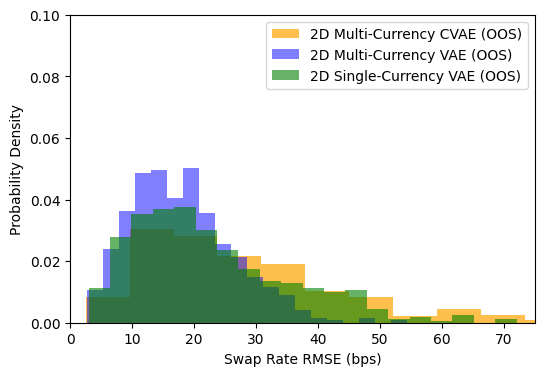

In [38]:
plt.figure(figsize=(6, 4))
plt.hist(daily_rmse_OOS_cvae, bins=20, density=True, alpha=0.7, color='orange', label='2D Multi-Currency CVAE (OOS)')
plt.hist(daily_rmse_OOS, bins=20, density=True, alpha=0.5, color='blue', label='2D Multi-Currency VAE (OOS)')
plt.hist(combined_vae_daily_rmse_OOS, bins=20, density=True, alpha=0.6, color='green', label='2D Single-Currency VAE (OOS)')
plt.xlabel('Swap Rate RMSE (bps)')
plt.ylabel('Probability Density')
plt.xlim(0, 75)
plt.ylim(0, 0.1)
plt.legend()
plt.savefig('3_vae_oos.png', dpi=300)
plt.show()

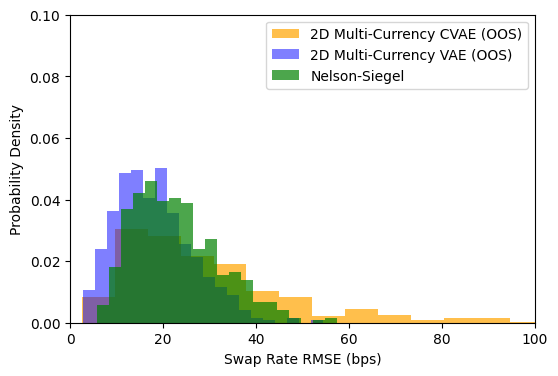

In [37]:
plt.figure(figsize=(6, 4))
plt.hist(daily_rmse_OOS_cvae, bins=20, density=True, alpha=0.7, color='orange', label='2D Multi-Currency CVAE (OOS)')
plt.hist(daily_rmse_OOS, bins=20, density=True, alpha=0.5, color='blue', label='2D Multi-Currency VAE (OOS)')
plt.hist(daily_rmse_ns, bins=20, density=True, alpha=.7, color='green', label='Nelson-Siegel')
plt.xlabel('Swap Rate RMSE (bps)')
plt.ylabel('Probability Density')
plt.xlim(0, 100)
plt.ylim(0, 0.1)
plt.legend()
# plt.savefig('oos_mvae_ns.png', dpi=300)
plt.show()

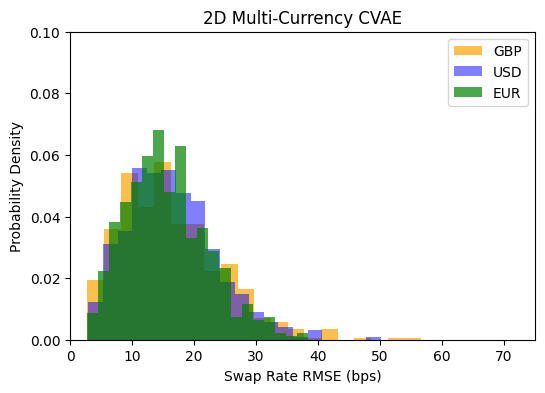

In [39]:
plt.figure(figsize=(6, 4))

plt.hist(gbp_cvae_daily_rmse, bins=20, density=True, alpha=.7, color='orange', label='GBP')
plt.hist(usd_cvae_daily_rmse, bins=20, density=True, alpha=0.5, color='blue', label='USD')
plt.hist(eur_cvae_daily_rmse, bins=20, density=True, alpha=0.7, color='green', label='EUR')
plt.title('2D Multi-Currency CVAE')
plt.xlabel('Swap Rate RMSE (bps)')
plt.ylabel('Probability Density')
plt.xlim(0, 75)
plt.ylim(0, 0.1)
plt.legend()
# plt.savefig('rmse_cvae.png', dpi=300)
plt.show()

### Example of training a 2D Multi-Currency VAE on in-sample data and testing on out-of-sample data

In [40]:
# Getting in-sample rmse and out-of-sample rmse using the optimal beta found previously
combined_dfs = pd.concat((gbp_ois_7_mat.copy(), usd_sofr_7_mat.copy()))
combined_dfs = pd.concat((combined_dfs, eur_estr_7_mat.copy()))
combined_swaps = combined_dfs
combined_swaps = combined_swaps.sample(frac=1).reset_index(drop=True)
split = 0.80
split_idx = int(combined_swaps.shape[0] * split)
combined_swaps_train = combined_swaps.iloc[:split_idx, :]
combined_swaps_test = combined_swaps.iloc[split_idx:, :]
combined_swaps_test = combined_swaps_test.iloc[:, 1:].values
scaled_swaps_train, scaler, index_set = multi_currency_scale_swaps(conditional=False, combined=combined_swaps_train)
encoder = build_encoder(latent_dims=2, num_maturities=7, type='multi_currency')
decoder = build_decoder(latent_dims=2, num_maturities=7, type='multi_currency')
vae = VAE(encoder, decoder, beta=1e-03)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(scaled_swaps_train, epochs=50, batch_size=8)
scaled_swaps_test = scaler.transform(combined_swaps_test)
mean, logvar, z = vae.encoder(scaled_swaps_test)
reconstructed_test_swaps = vae.decoder(z).numpy()
reconstructed_test_swaps = scaler.inverse_transform(reconstructed_test_swaps)

mean_IS, logvar_IS, z_IS = vae.encoder(scaled_swaps_train)
reconstructed_train_swaps = vae.decoder(z_IS).numpy()
reconstructed_train_swaps = scaler.inverse_transform(reconstructed_train_swaps)

daily_rmse_OOS = calculate_rmse(reconstructed_test_swaps, combined_swaps_test)
daily_rmse_IS = calculate_rmse(reconstructed_train_swaps, combined_swaps_train.iloc[:, 1:])
print(np.mean(daily_rmse_OOS))
print(np.mean(daily_rmse_IS))

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - kl_loss: 2.0966e-04 - loss: 0.0484 - reconstruction_loss: 0.0482 - total_loss: 0.0459
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 5.4535e-04 - loss: 0.0324 - reconstruction_loss: 0.0318 - total_loss: 0.0249
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0011 - loss: 0.0089 - reconstruction_loss: 0.0079 - total_loss: 0.0071
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0012 - loss: 0.0055 - reconstruction_loss: 0.0043 - total_loss: 0.0052
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0013 - loss: 0.0049 - reconstruction_loss: 0.0036 - total_loss: 0.0047
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - kl_loss: 0.0013 - loss: 0.0048 - reconstruction_loss: 0.0034 - total_loss: 0.0045
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0013 - loss: 0.0045 - reconstruction_loss: 0.0032 - total_loss: 0.0044
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━

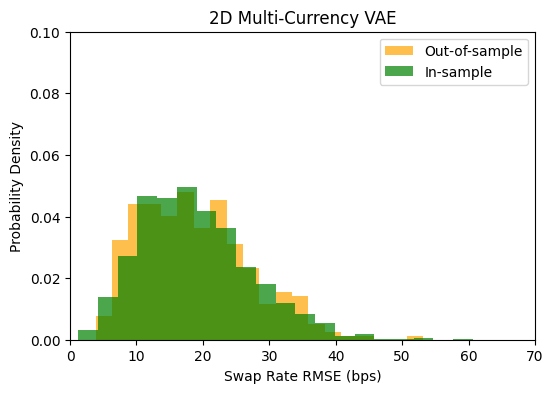

In [41]:
plt.figure(figsize=(6, 4))
plt.hist(daily_rmse_OOS, bins=20, density=True, alpha=.7, color='orange', label='Out-of-sample')
plt.hist(daily_rmse_IS, bins=20, density=True, alpha=.7, color='green', label='In-sample')
plt.title('2D Multi-Currency VAE')
plt.xlabel('Swap Rate RMSE (bps)')
plt.ylabel('Probability Density')
plt.xlim(0, 70)
plt.ylim(0, 0.1)
plt.legend()
# plt.savefig('is_oos_rmse2.png', dpi=300)
plt.show()

### Exploring properties of the latent space and how the position in the latent space affects curve shapes
We first use the 2-d multi-currency VAE to encode the GBP swaps data to get its latent space representation, and then plot a 2-standard deviation confidence ellipse around the points in the latent space. We then explore what kind of change in curve shape is achieved from traversing the major axis, minor axis, and the boundary of the ellipse. This will give us an idea of the patterns/shapes that the VAE is able to represent using just a 2-dimensional latent space.

In [42]:
from matplotlib.patches import Ellipse

def confidence_ellipse(x, y, ax, n_std=1.0, facecolor='none', **kwargs):
    cov = np.cov(x, y)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    
    if lambda_[0] < lambda_[1]:
        lambda_ = np.flip(lambda_)
        v = np.flip(v, axis=1)
    
    angle = np.degrees(np.arctan2(*v[:, 0][::-1]))
    
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0] * n_std * 2, height=lambda_[1] * n_std * 2,
                  angle=angle, **kwargs)
    
    ell.set_facecolor(facecolor)
    ax.add_patch(ell)
    
    return ell

def ellipse_boundary(h, k, a, b, theta, num_points=20):
    t = np.linspace(0, 2*np.pi, num_points)
    x = h + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
    y = k + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)
    return x, y

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


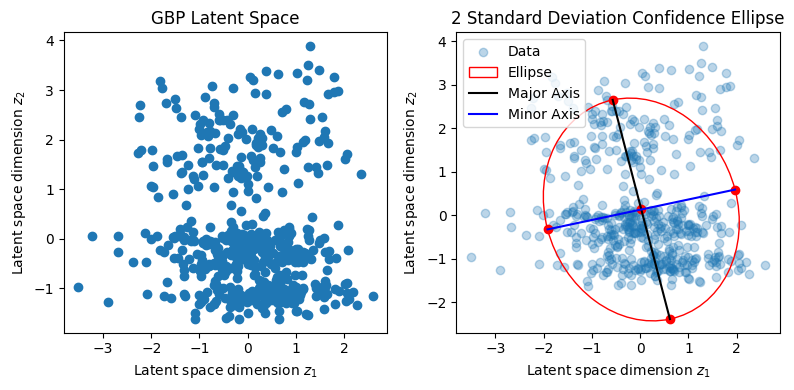

In [43]:
_, _, z_gbp = mc_vae.encoder.predict(gbp_scaled_swaps)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(z_gbp[:, 0], z_gbp[:, 1])
plt.xlabel("Latent space dimension $z_1$")
plt.ylabel("Latent space dimension $z_2$")
plt.title("GBP Latent Space")

plt.subplot(1, 2, 2)
plt.scatter(z_gbp[:, 0], z_gbp[:, 1], label='Data', alpha=0.3)
# Plotting 2 standard deviation confidence ellipse
origin = np.mean(z_gbp, axis=0)
ax = plt.gca()
ell = confidence_ellipse(z_gbp[:, 0], z_gbp[:, 1], ax, n_std=2, edgecolor='red', label='Ellipse')
ellipse_patch = ax.patches[-1]
p1, p2 = ell.get_vertices()
p3, p4 = ell.get_co_vertices()
pc1_x_linspace = np.linspace(p1[0], p2[0], 10)
pc1_y_linspace = np.linspace(p1[1], p2[1], 10)
pc2_x_linspace = np.linspace(p3[0], p4[0], 10)
pc2_y_linspace = np.linspace(p3[1], p4[1], 10)

plt.xlabel("Latent space dimension $z_1$")
plt.ylabel("Latent space dimension $z_2$")
plt.title('2 Standard Deviation Confidence Ellipse')
# Plotting vertices
plt.scatter(p1[0], p1[1], color='red') 
plt.scatter(p2[0], p2[1], color='red')
# Plotting co-vertices
plt.scatter(p3[0], p3[1], color='red')
plt.scatter(p4[0], p4[1], color='red')
plt.plot(pc1_x_linspace, pc1_y_linspace, color='black', label='Major Axis')
plt.plot(pc2_x_linspace, pc2_y_linspace, color='b', label='Minor Axis')
# plt.xlim(-4, 3)
# plt.ylim(-1, 6)

plt.scatter(origin[0], origin[1], color='red')

plt.legend()

plt.tight_layout()
# plt.savefig('ellipse.png', dpi=300)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


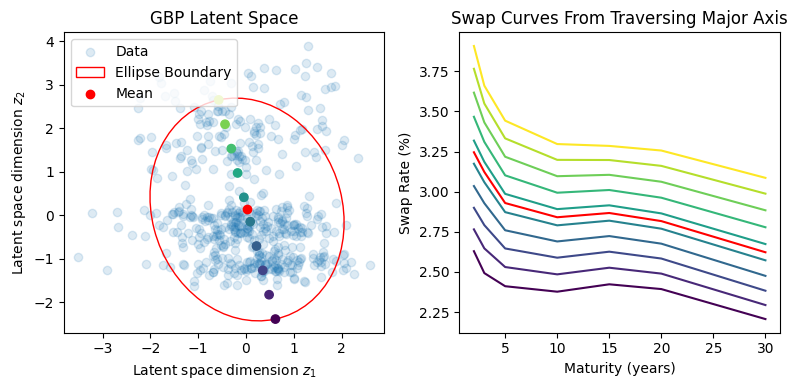

In [44]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(z_gbp[:, 0], z_gbp[:, 1], label='Data', alpha=0.15)
plt.xlabel("Latent space dimension $z_1$")
plt.ylabel("Latent space dimension $z_2$")
plt.title('GBP Latent Space')
ax = plt.gca()
ell = confidence_ellipse(z_gbp[:, 0], z_gbp[:, 1], ax, n_std=2, edgecolor='red', label='Ellipse Boundary')
ellipse_patch = ax.patches[-1]
cmap = plt.get_cmap('viridis')
colors = [cmap(i/10) for i in range(10)]
plt.scatter(pc1_x_linspace, pc1_y_linspace, color=colors)
# plt.xlim(-4, 3)
# plt.ylim(-1, 6)
plt.scatter(origin[0], origin[1], color='r', label='Mean')
plt.legend()

plt.subplot(1, 2, 2)
pc2_traverse_swaps = mc_vae.decoder.predict(np.column_stack((pc2_x_linspace, pc2_y_linspace)))
pc2_traverse_swaps_mean = mc_vae.decoder.predict(np.array([origin[0], origin[1]]).reshape((1, 2)))
pc2_traverse_swaps = multi_curr_scaler.inverse_transform(pc2_traverse_swaps)
pc2_traverse_swaps_mean = multi_curr_scaler.inverse_transform(pc2_traverse_swaps_mean)
cmap = plt.get_cmap('viridis')
num_lines = pc2_traverse_swaps.shape[0]
for i in range(len(pc2_traverse_swaps)):
    color = cmap(i / (num_lines - 1))
    plt.plot(seven_mat, pc2_traverse_swaps[i, :], color=color)

plt.plot(seven_mat, pc2_traverse_swaps_mean[0, :], color='red')

plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('Swap Curves From Traversing Major Axis')

plt.tight_layout()
# plt.savefig('traverse_major_axis.png', dpi=300)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


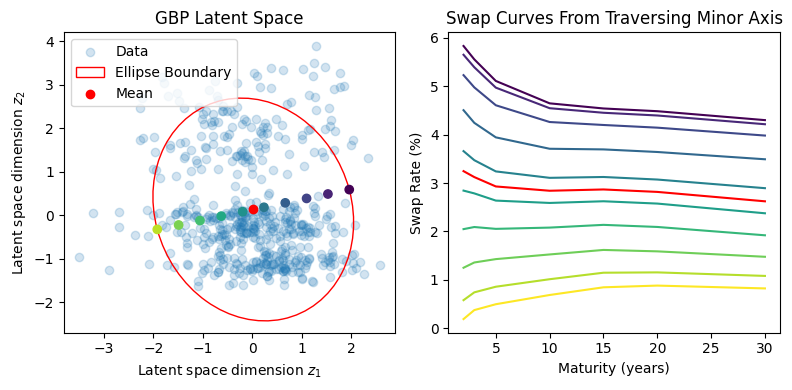

In [45]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(z_gbp[:, 0], z_gbp[:, 1], label='Data', alpha=0.2)
plt.xlabel("Latent space dimension $z_1$")
plt.ylabel("Latent space dimension $z_2$")
plt.title('GBP Latent Space')
ax = plt.gca()
ell = confidence_ellipse(z_gbp[:, 0], z_gbp[:, 1], ax, n_std=2, edgecolor='red', label='Ellipse Boundary')
ellipse_patch = ax.patches[-1]
cmap = plt.get_cmap('viridis')
colors = [cmap(i/10) for i in range(10)]
plt.scatter(pc2_x_linspace, pc2_y_linspace, color=colors)
# plt.xlim(-2, 0)
# plt.ylim(1.5, 3.5)
plt.scatter(origin[0], origin[1], color='r', label='Mean')
plt.legend()

plt.subplot(1, 2, 2)
pc1_traverse_swaps = mc_vae.decoder.predict(np.column_stack((pc1_x_linspace, pc1_y_linspace)))
pc1_traverse_swaps_mean = mc_vae.decoder.predict(np.array([origin[0], origin[1]]).reshape((1, 2)))
pc1_traverse_swaps = multi_curr_scaler.inverse_transform(pc1_traverse_swaps)
pc1_traverse_swaps_mean = multi_curr_scaler.inverse_transform(pc1_traverse_swaps_mean)
cmap = plt.get_cmap('viridis')
num_lines = pc1_traverse_swaps.shape[0]
for i in range(len(pc1_traverse_swaps)):
    color = cmap(i / (num_lines - 1))
    plt.plot(seven_mat, pc1_traverse_swaps[i, :], color=color)

plt.plot(seven_mat, pc1_traverse_swaps_mean[0, :], color='red')

plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('Swap Curves From Traversing Minor Axis')

plt.tight_layout()
plt.savefig('traverse_minor_axis.png', dpi=300)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


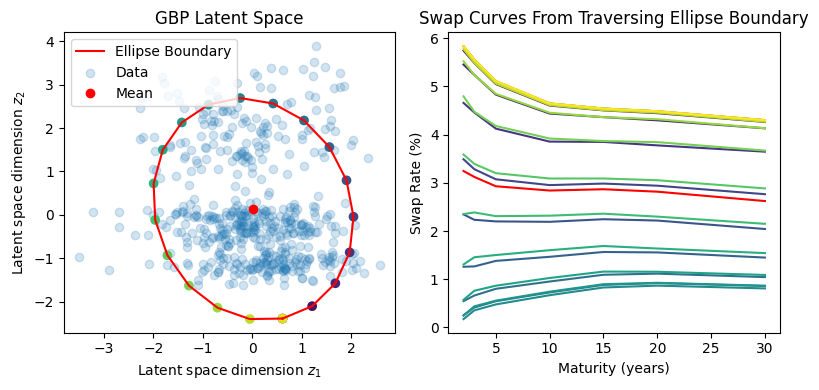

In [46]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
semi_minor_axis = ell.get_height() / 2
semi_major_axis = ell.get_width() / 2
angle = (ell.get_angle() * np.pi) / 180
num_points = 20
x_boundary, y_boundary = ellipse_boundary(origin[0], origin[1], semi_major_axis, semi_minor_axis, angle, num_points=num_points)
plt.plot(x_boundary, y_boundary, color='red', label='Ellipse Boundary')
plt.scatter(z_gbp[:, 0], z_gbp[:, 1], label='Data', alpha=0.2)
plt.plot(origin[0], origin[1], 'ro', label='Mean')
cmap = plt.get_cmap('viridis')
colors = [cmap(i/num_points) for i in range(num_points)]
plt.scatter(x_boundary, y_boundary, color=colors)
plt.xlabel("Latent space dimension $z_1$")
plt.ylabel("Latent space dimension $z_2$")
plt.title('GBP Latent Space')
plt.legend()

plt.subplot(1, 2, 2)
ellipse_boundary_swaps = mc_vae.decoder.predict(np.column_stack((x_boundary, y_boundary)))
ellipse_boundary_swaps = multi_curr_scaler.inverse_transform(ellipse_boundary_swaps)
cmap = plt.get_cmap('viridis')
num_lines = ellipse_boundary_swaps.shape[0]
for i in range(len(ellipse_boundary_swaps)):
    color = cmap(i / (num_lines - 1))
    plt.plot(seven_mat, ellipse_boundary_swaps[i, :], color=color)
plt.plot(seven_mat, pc2_traverse_swaps_mean[0, :], color='red')
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('Swap Curves From Traversing Ellipse Boundary')

plt.tight_layout()
# plt.savefig('traverse_perimeter.png', dpi=300)
plt.show()

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
mean_centered_data = std_scaler.fit_transform(z_gbp)
covariance_matrix = np.cov(mean_centered_data.T)
pca = PCA(n_components=2)
pca.fit(mean_centered_data)
principal_components = pca.components_
eigenvalues = pca.explained_variance_
major_axis1 = principal_components[0]
minor_axis1 = principal_components[1]
pca_mean = pca.mean_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


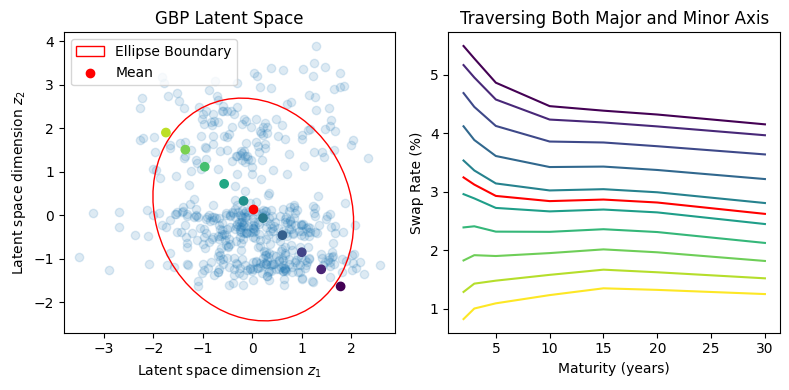

In [48]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
m = 0.5
test = np.linspace([m, m], [-m, -m], 10) * np.array([5*major_axis1[0], 5*major_axis1[1]]) + origin
test = test[::-1]
plt.scatter(z_gbp[:, 0], z_gbp[:, 1], alpha=0.15)
ax = plt.gca()
ell = confidence_ellipse(z_gbp[:, 0], z_gbp[:, 1], ax, n_std=2, edgecolor='red', label='Ellipse Boundary')
ellipse_patch = ax.patches[-1]
cmap = plt.get_cmap('viridis')
colors = [cmap(i/10) for i in range(10)]
plt.scatter(test[:, 0], test[:, 1], color=colors)
plt.scatter(origin[0], origin[1], color='r', label='Mean')
plt.xlabel("Latent space dimension $z_1$")
plt.ylabel("Latent space dimension $z_2$")
plt.title('GBP Latent Space')
plt.legend()

plt.subplot(1, 2, 2)
pc_swaps = mc_vae.decoder.predict(test)
pc_swaps = multi_curr_scaler.inverse_transform(pc_swaps)
cmap = plt.get_cmap('viridis')
num_lines = pc_swaps.shape[0]
for i in range(len(pc_swaps)):
    color = cmap(i / (num_lines - 1))
    plt.plot(seven_mat, pc_swaps[i, :], color=color)
plt.plot(seven_mat, pc2_traverse_swaps_mean[0, :], color='red')
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('Traversing Both Major and Minor Axis')

plt.tight_layout()
# plt.savefig('traversing_major_minor.png', dpi=300)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


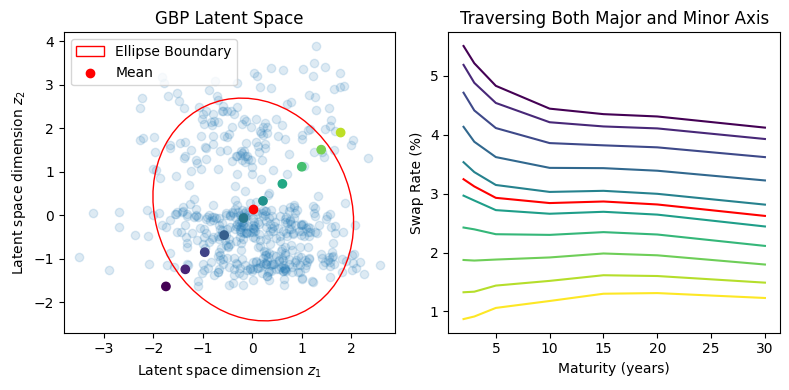

In [49]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
m = 0.5
test = np.linspace([m, m], [-m, -m], 10) * np.array([5*minor_axis1[0], 5*minor_axis1[1]]) + origin
plt.scatter(z_gbp[:, 0], z_gbp[:, 1], alpha=0.15)
ax = plt.gca()
ell = confidence_ellipse(z_gbp[:, 0], z_gbp[:, 1], ax, n_std=2, edgecolor='red', label='Ellipse Boundary')
ellipse_patch = ax.patches[-1]
cmap = plt.get_cmap('viridis')
colors = [cmap(i/10) for i in range(10)]
plt.scatter(test[:, 0], test[:, 1], color=colors)
plt.scatter(origin[0], origin[1], color='r', label='Mean')
plt.xlabel("Latent space dimension $z_1$")
plt.ylabel("Latent space dimension $z_2$")
plt.title('GBP Latent Space')
plt.legend()

plt.subplot(1, 2, 2)
pc_swaps = mc_vae.decoder.predict(test)
pc_swaps = multi_curr_scaler.inverse_transform(pc_swaps)
cmap = plt.get_cmap('viridis')
num_lines = pc_swaps.shape[0]
for i in range(len(pc_swaps)):
    color = cmap(i / (num_lines - 1))
    plt.plot(seven_mat, pc_swaps[i, :], color=color)
plt.plot(seven_mat, pc2_traverse_swaps_mean[0, :], color='red')
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('Traversing Both Major and Minor Axis')

plt.tight_layout()
# plt.savefig('traversing_major_minor_2.png', dpi=300)
plt.show()

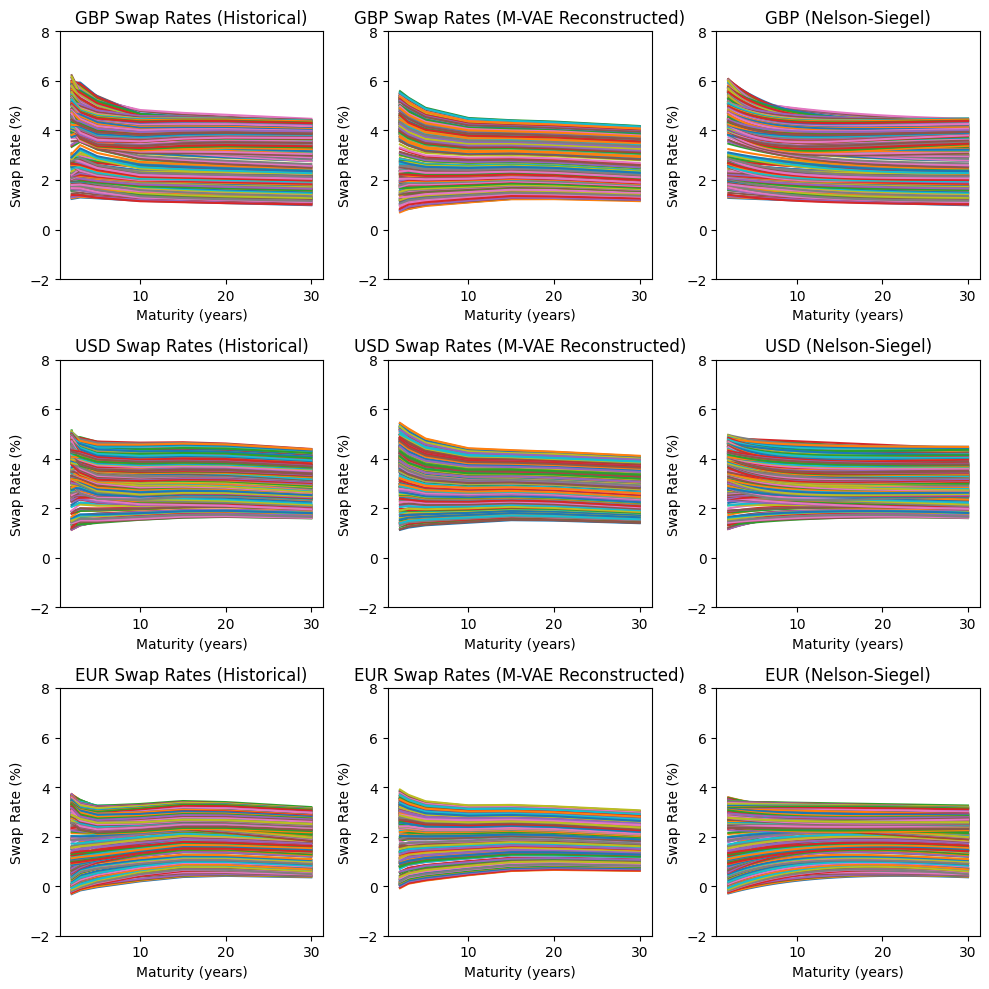

In [50]:
plt.figure(figsize=(10, 10))

# Plotting Historical GBP Swap Rates
plt.subplot2grid((3, 3), (0, 0), colspan=1)
for i in range(len(gbp_ois_7_mat)):
    plt.plot(seven_mat, gbp_ois_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('GBP Swap Rates (Historical)')
plt.ylim(-2, 8)

# Plotting M-VAE Reconstructed GBP Swap Rates
plt.subplot2grid((3, 3), (0, 1), colspan=1)
for i in range(gbp_reconstructed_mc_swaps.shape[0]):
    plt.plot(seven_mat, gbp_reconstructed_mc_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('GBP Swap Rates (M-VAE Reconstructed)')
plt.ylim(-2, 8)

# Plotting GBP NS
plt.subplot2grid((3, 3), (0, 2), colspan=1)
for i in range(gbp_ns_swaps.shape[0]):
    plt.plot(t, gbp_ns_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('GBP (Nelson-Siegel)')
plt.ylim(-2, 8)

# Plotting Historical USD Swap Rates
plt.subplot2grid((3, 3), (1, 0), colspan=1)
for i in range(len(usd_sofr_7_mat)):
    plt.plot(seven_mat, usd_sofr_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('USD Swap Rates (Historical)')
plt.ylim(-2, 8)

# Plotting M-VAE Reconstructed USD Swap Rates
plt.subplot2grid((3, 3), (1, 1), colspan=1)
for i in range(usd_reconstructed_mc_swaps.shape[0]):
    plt.plot(seven_mat, usd_reconstructed_mc_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('USD Swap Rates (M-VAE Reconstructed)')
plt.ylim(-2, 8)

# Plotting USD NS
plt.subplot2grid((3, 3), (1, 2), colspan=1)
for i in range(usd_ns_swaps.shape[0]):
    plt.plot(t, usd_ns_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('USD (Nelson-Siegel)')
plt.ylim(-2, 8)

# Plotting Historical EUR Swap Rates
plt.subplot2grid((3, 3), (2, 0), colspan=1)
for i in range(len(eur_estr_7_mat)):
    plt.plot(seven_mat, eur_estr_7_mat.iloc[i, 1:].values)
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('EUR Swap Rates (Historical)')
plt.ylim(-2, 8)

# Plotting M-VAE Reconstructed EUR Swap Rates
plt.subplot2grid((3, 3), (2, 1), colspan=1)
for i in range(eur_reconstructed_mc_swaps.shape[0]):
    plt.plot(seven_mat, eur_reconstructed_mc_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('EUR Swap Rates (M-VAE Reconstructed)')
plt.ylim(-2, 8)

# Plotting EUR NS
plt.subplot2grid((3, 3), (2, 2), colspan=1)
for i in range(eur_ns_swaps.shape[0]):
    plt.plot(t, eur_ns_swaps[i])
plt.xlabel('Maturity (years)')
plt.ylabel('Swap Rate (%)')
plt.title('EUR (Nelson-Siegel)')
plt.ylim(-2, 8)

plt.tight_layout()
# plt.savefig('3x3_curves2.png', dpi=300)
plt.show()

### Forward Rate Models in Q-Measure

In [51]:
def partial_derivative(model, scaler, F, k, epsilon=0.001):
    """
    Calculate the partial derivative of the VAE's output with respect to
    the k-th latent variable, numerically.

    :param model: Your VAE model which includes the method to map F to z(F) and reconstruct it back.
    :param F: The input forward curve.
    :param k: The index of the latent variable with respect to which to differentiate.
    :param epsilon: A small value to approximate the derivative.
    :return: The estimated partial derivative.
    """
    # Encode F to get z(F)
    mean, logvar, z = model.encoder(F)

    z1 = np.array(z)
    z2 = np.array(z)

    if k == 0:
    # Perturb the k-th component of z by a small amount in the positive direction
        z1[:,0] += epsilon
        F_plus = model.decoder(z1).numpy()
        F_plus = scaler.inverse_transform(F_plus)

    # Perturb the k-th component of z by a small amount in the negative direction
        z2[:,0] -= epsilon
        F_minus = model.decoder(z2).numpy()
        F_minus = scaler.inverse_transform(F_minus)

    if k == 1:
        z1[:,1] += epsilon
        F_plus = model.decoder(z1).numpy()
        F_plus = scaler.inverse_transform(F_plus)

    # Perturb the k-th component of z by a small amount in the negative direction
        z2[:,1] -= epsilon
        F_minus = model.decoder(z2).numpy()
        F_minus = scaler.inverse_transform(F_minus)

    # Calculate the partial derivative using the central difference formula
    derivative = (F_plus - F_minus) / (2 * epsilon)
    return derivative

#### Numerical Example (using correlation between different rates)

In [64]:
X = gbp_ois_7_mat.copy()
X_train = X.iloc[250:,:]
X_test = X.iloc[:250,:]

# Transforming the swaps data so that it can be passed into the single-currency VAE (using GBP in this example)
train, gbp_scaler = single_currency_scale_swaps(X_train)
test, gbp_scaler = single_currency_scale_swaps(X_test)

# Creating the encoder and decoder for single-currency VAE
gbp_encoder = build_encoder(latent_dims=2, num_maturities=7, type='single_currency')
gbp_decoder = build_decoder(latent_dims=2, num_maturities=7, type='single_currency')
gbp_vae = VAE(gbp_encoder, gbp_decoder, beta=1e-3)
gbp_vae.compile(optimizer=keras.optimizers.Adam())
gbp_vae.fit(train, epochs=50, batch_size=8)
mean, logvar, z = gbp_vae.encoder(test)
reconstructed_swaps = gbp_vae.decoder(z).numpy()
reconstructed_swaps = gbp_scaler.inverse_transform(reconstructed_swaps)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - kl_loss: 1.6915e-04 - loss: 0.0681 - reconstruction_loss: 0.0678 - total_loss: 0.0643
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 3.0608e-04 - loss: 0.0634 - reconstruction_loss: 0.0630 - total_loss: 0.0628
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 4.5807e-04 - loss: 0.0597 - reconstruction_loss: 0.0593 - total_loss: 0.0601
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - kl_loss: 5.4849e-04 - loss: 0.0570 - reconstruction_loss: 0.0565 - total_loss: 0.0560
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - kl_loss: 6.2138e-04 - loss: 0.0508 - reconstruction_loss: 0.0502 - total_loss: 0.0504
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 7.2091e-04 - loss: 0.0456 - reconstruction_loss: 0.0450 - total_loss: 0.0491
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 6.9827e-04 - loss: 0.0443 - reconstruction_loss: 0.0436 - total_loss: 0.0446
Epoch 8/50
34/34 ━━━━━━━━━━━━━

In [65]:
volatilities_z0 = pd.DataFrame(partial_derivative(gbp_vae, gbp_scaler, test, k=0), columns=['Vol 2Y', 'Vol 3Y', 'Vol 5Y', 'Vol 10Y', 'Vol 15Y', 'Vol 20Y', 'Vol 30Y'])
volatilities_z1 = pd.DataFrame(partial_derivative(gbp_vae, gbp_scaler, test, k=1), columns=['Vol 2Y', 'Vol 3Y', 'Vol 5Y', 'Vol 10Y', 'Vol 15Y', 'Vol 20Y', 'Vol 30Y'])
volatilities = volatilities_z0 + volatilities_z1

In [66]:
volatilities.head()

,Vol 2Y,Vol 3Y,Vol 5Y,Vol 10Y,Vol 15Y,Vol 20Y,Vol 30Y
0,0.156701,0.149727,0.137508,0.218391,0.188470,0.233710,0.199914
1,0.044882,0.046909,0.042140,0.062764,0.053704,0.064850,0.058472
2,0.084639,0.089109,0.100791,0.107050,0.094295,0.124156,0.100255
3,0.176072,0.201344,0.180066,0.243187,0.173330,0.229239,0.199318
4,0.034928,0.053644,0.047982,0.046670,0.022769,0.033736,0.032604


In [67]:
# Calculate the changes in rates (assuming simple differences for illustration)
changes = np.diff(X_test.iloc[:,1:], axis=0)

# Calculate the empirical correlation matrix from these changes
correlation_matrix = np.corrcoef(changes.T)
empirical_correlation = pd.DataFrame(correlation_matrix, 
                                       columns=['2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y'],
                                       index=['2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y'])
empirical_correlation

,2Y,3Y,5Y,10Y,15Y,20Y,30Y
2Y,1.000000,0.057636,0.084075,0.078853,0.089263,0.085306,0.091040
3Y,0.057636,1.000000,0.977410,0.893101,0.854813,0.824147,0.782208
5Y,0.084075,0.977410,1.000000,0.959147,0.933634,0.910012,0.874761
10Y,0.078853,0.893101,0.959147,1.000000,0.990345,0.971604,0.945715
15Y,0.089263,0.854813,0.933634,0.990345,1.000000,0.992928,0.979144
20Y,0.085306,0.824147,0.910012,0.971604,0.992928,1.000000,0.992159
30Y,0.091040,0.782208,0.874761,0.945715,0.979144,0.992159,1.000000


In [69]:
drift_ = []
for i in range(7):
    sum_ = 0.
    for j in range(i):
        sum_ += np.divide((empirical_correlation.values[i, j] * volatilities.values[:,j]),(1+X_test.iloc[:,j+1].values))
    drift = volatilities.values[:,i] + sum_
    drift_.append(drift)
drift_ = np.array(drift_)
drift_df = pd.DataFrame(drift_.T, columns = ['Drift 2Y', 'Drift 3Y', 'Drift 5Y', 'Drift 10Y', 'Drift 15Y', 'Drift 20Y', 'Drift 30Y']) 
drift_df.head()

,Drift 2Y,Drift 3Y,Drift 5Y,Drift 10Y,Drift 15Y,Drift 20Y,Drift 30Y
0,0.156701,0.153768,0.207197,0.340569,0.407540,0.535657,0.605741
1,0.044882,0.048050,0.063542,0.100067,0.118464,0.152870,0.174746
2,0.084639,0.091199,0.140239,0.184650,0.217327,0.286812,0.315648
3,0.176072,0.205715,0.268921,0.398678,0.432699,0.560868,0.627819
4,0.034928,0.054519,0.071475,0.088108,0.084002,0.103853,0.116394


#### Numerical Example (using independent shocks, i.e. no correlation between different forward rates)

In [71]:
drift_df = pd.DataFrame((np.square(volatilities.values)) / ((X_test.iloc[:,1:].values)+1), columns = ['Drift 2Y', 'Drift 3Y', 'Drift 5Y', 'Drift 10Y', 
                                                                                                                    'Drift 15Y', 'Drift 20Y', 'Drift 30Y']) 
drift_df.head()

,Drift 2Y,Drift 3Y,Drift 5Y,Drift 10Y,Drift 15Y,Drift 20Y,Drift 30Y
0,0.010987,0.009773,0.008366,0.022099,0.016796,0.026431,0.020172
1,0.000888,0.000947,0.000778,0.001806,0.001349,0.002009,0.001696
2,0.003069,0.003318,0.004359,0.005143,0.004067,0.007190,0.004863
3,0.013352,0.016991,0.013920,0.026592,0.013795,0.024637,0.019323
4,0.000530,0.001219,0.000998,0.000991,0.000241,0.000543,0.000529
